## Compare the triangulation obtained with Pose2Sim for various camera combinations

By: Léa Drolet-Roy

Last modification: 2025-07-25

In [1]:
import numpy as np
import json
import os

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Rectangle, Patch

import seaborn as sns
import pandas as pd

import joblib
import itertools

from compare_keypoints_3D import draw_skeleton

In [2]:
with open('/home/lea/trampo/Pose2Sim/pose-3d-vit-multi/vit_reprojection_errors_cam_combi.json', 'r') as f:
    errors_seq_cam = json.load(f)

### Graph reprojection error according to number of cameras used

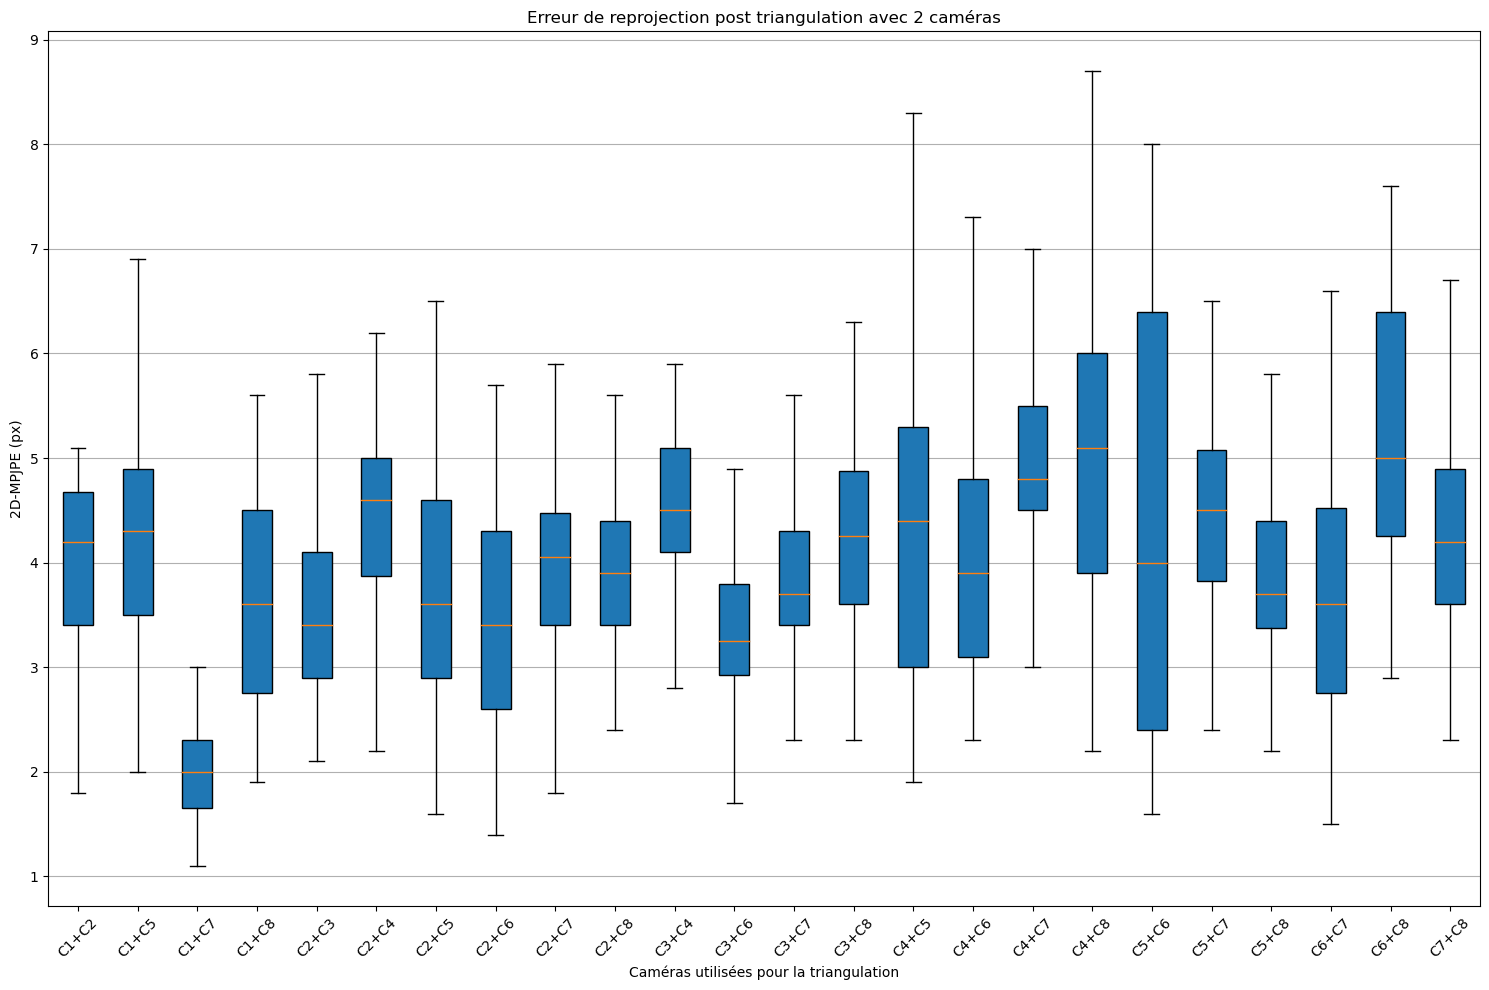

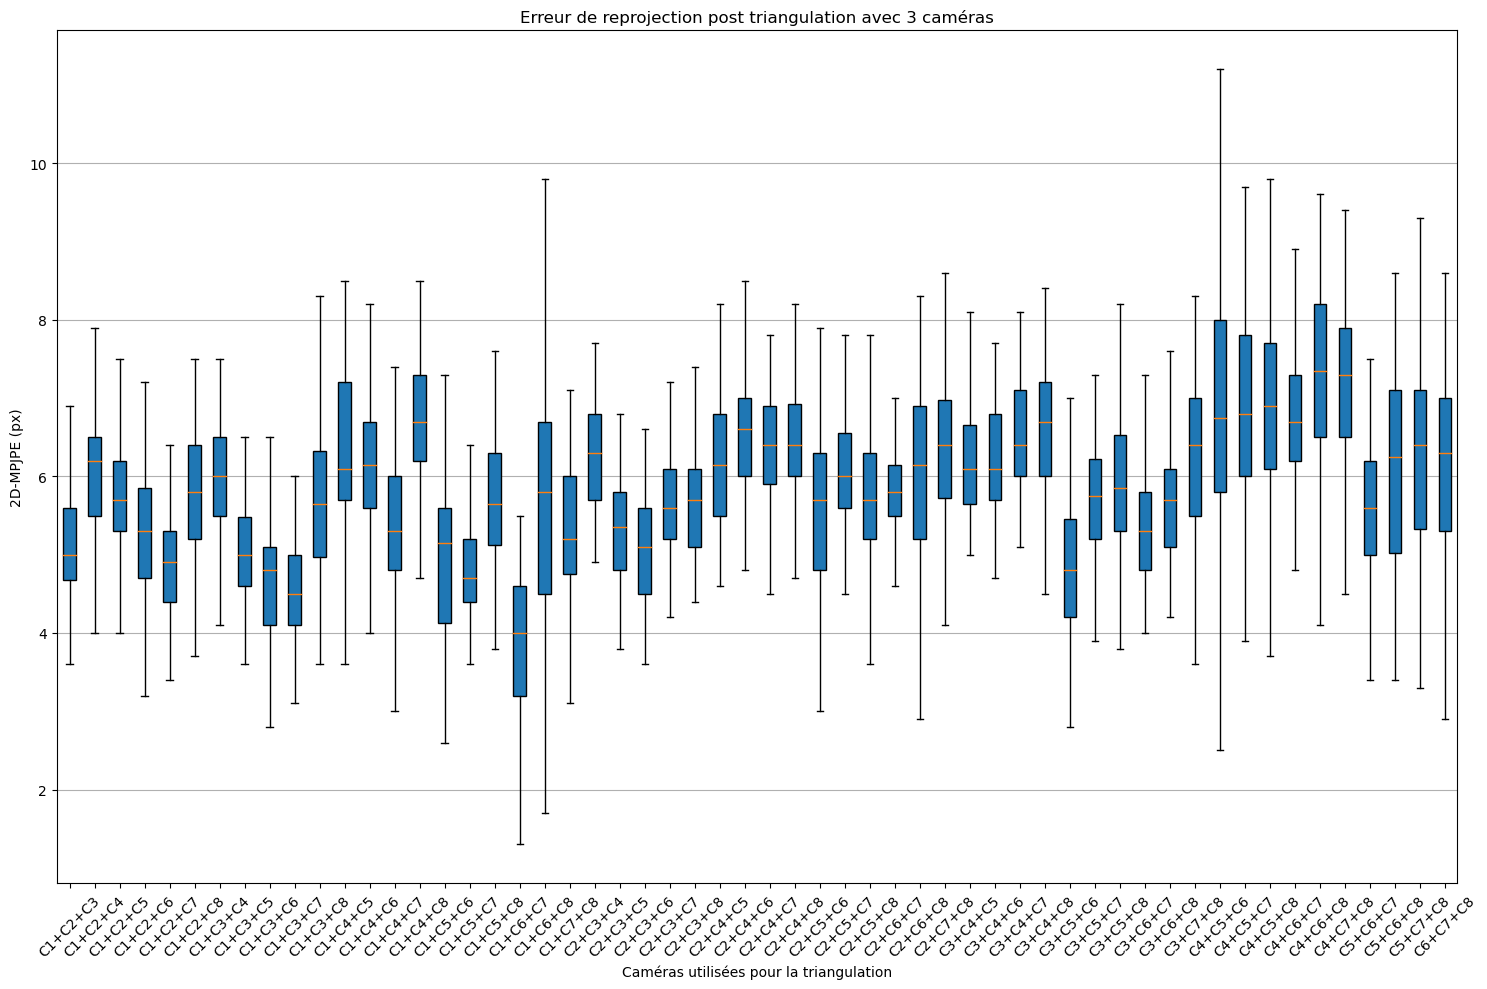

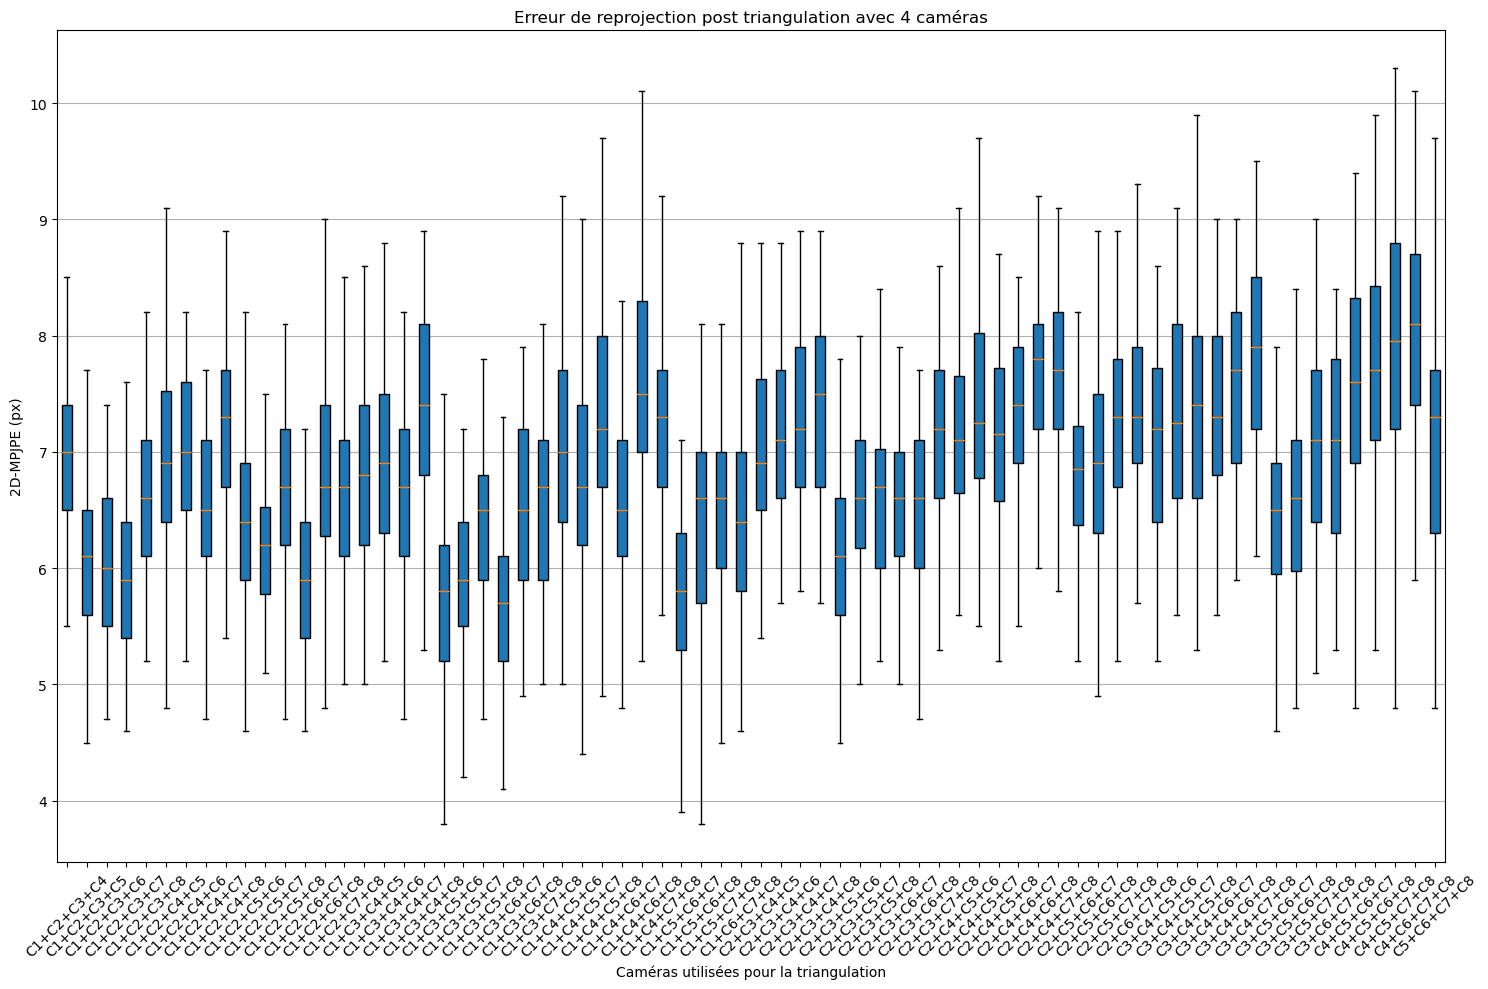

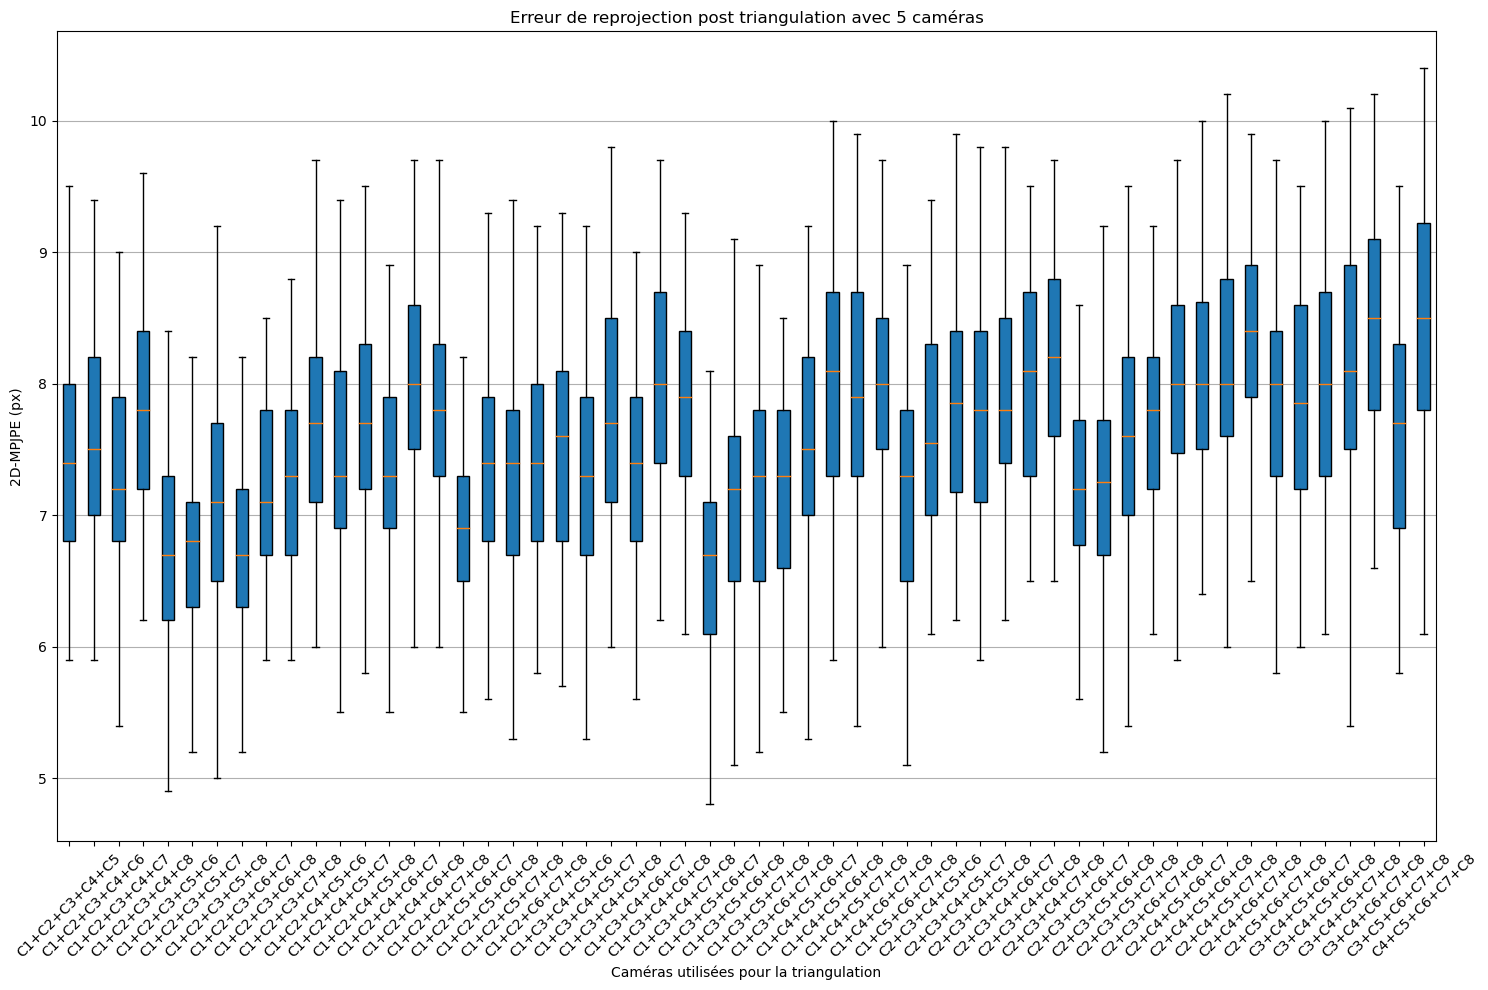

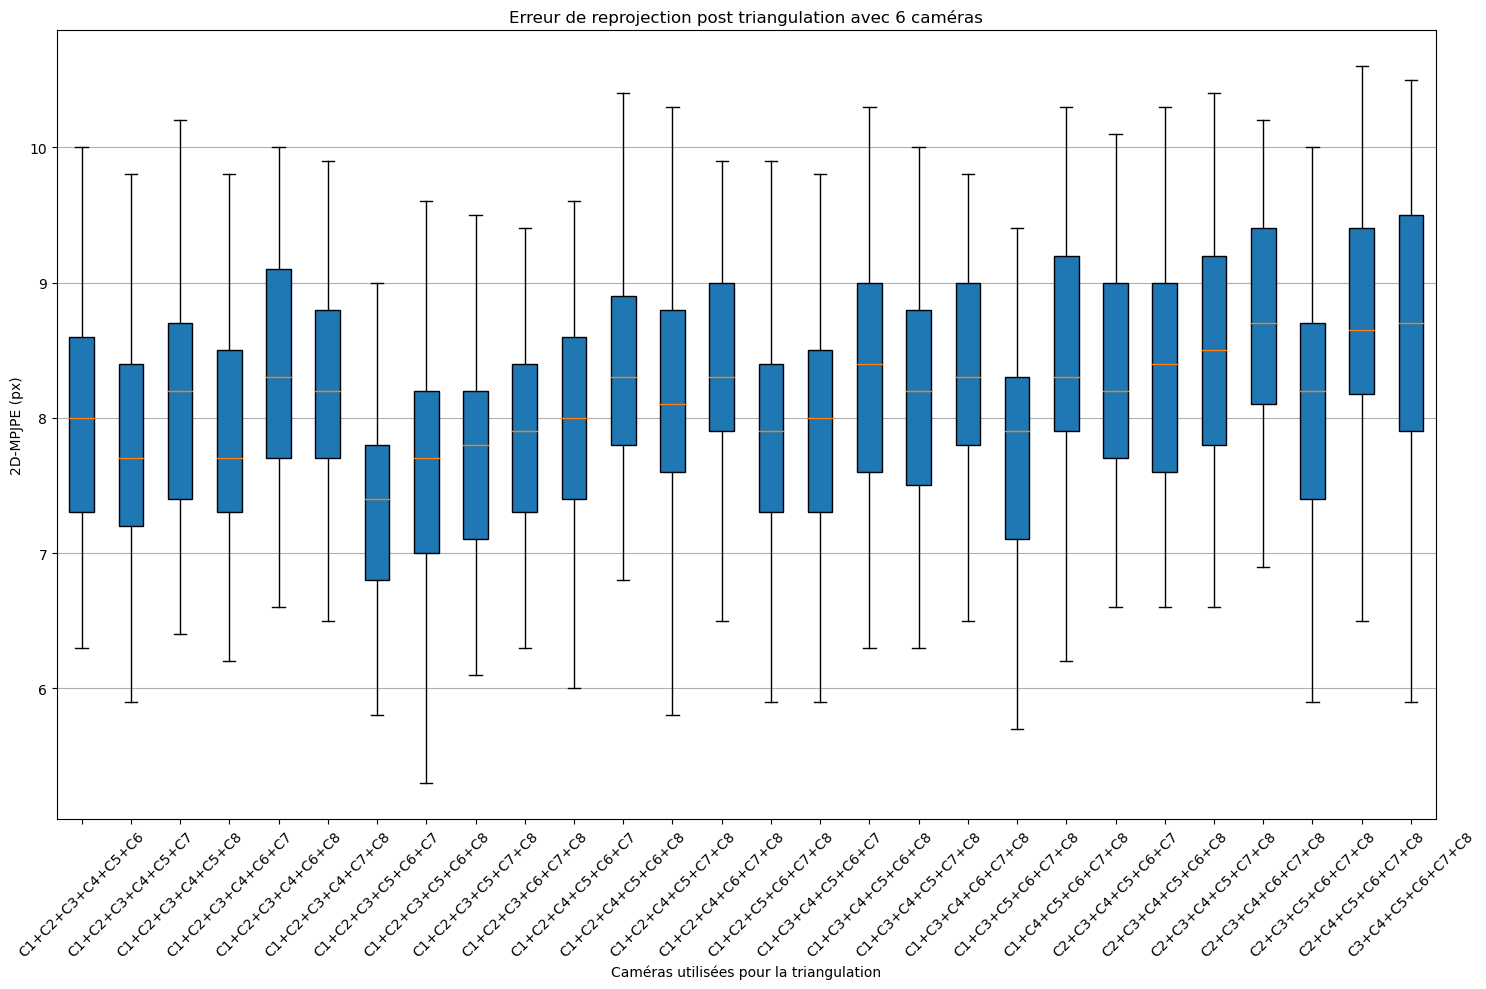

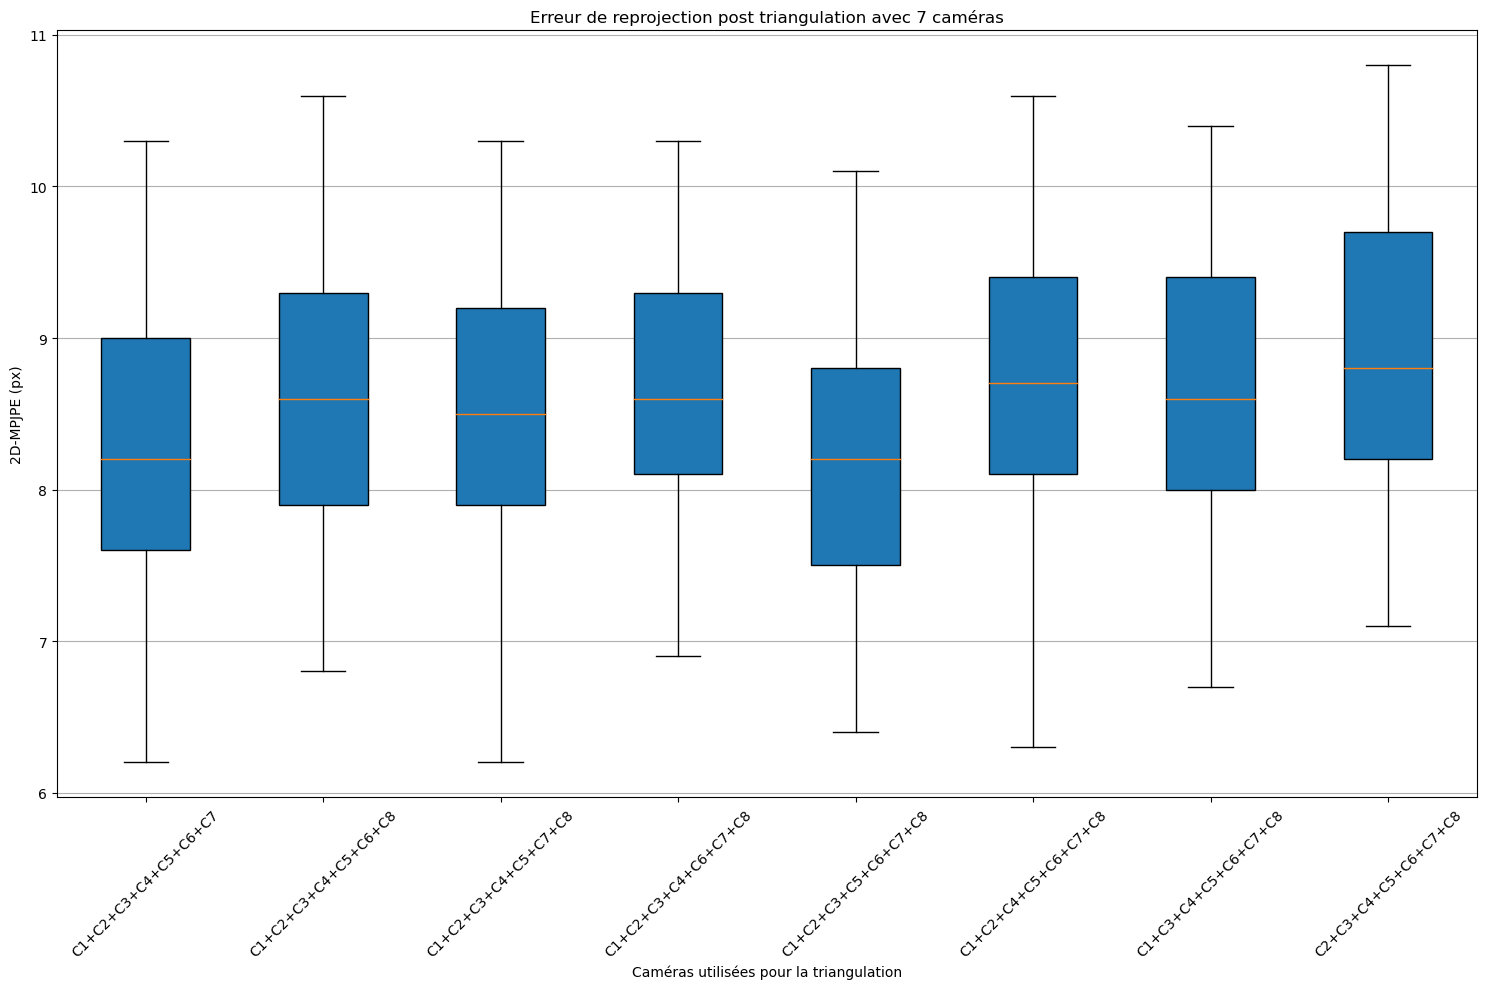

In [3]:
cam_keys = list(errors_seq_cam['2_partie_0429_000'].keys())

errors_all_cam = {i:{} for i in range(2,8)}

for c in cam_keys:
    errors_all_cam[len(c.split('+'))].update({c: []})

for seq, errors_cam in errors_seq_cam.items():
    for cam, error in errors_cam.items():
        try:
            errors_all_cam[len(cam.split('+'))][cam].append(error[0])
        except KeyError:
            continue

for i in range(2,8):
    labels = list(errors_all_cam[i].keys())
    valeurs = list(errors_all_cam[i].values())

    # Boxplot
    plt.figure(figsize=(15, 10))
    plt.boxplot(valeurs, labels=labels, patch_artist=True, showfliers=False)
    plt.xlabel('Caméras utilisées pour la triangulation')
    plt.ylabel('2D-MPJPE (px)')
    plt.title(f'Erreur de reprojection post triangulation avec {i} caméras')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()

    plt.savefig(f'/home/lea/trampo/metrics/Pose2Sim_triangulation_figs/vit_reprog_{i}_cameras.png')
    plt.show()

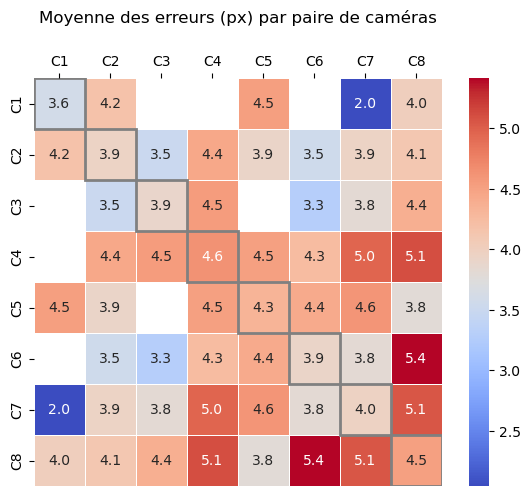

In [4]:
data = errors_all_cam[2]

# --- Étape 1 : détecter les caméras uniques ---
camera_names = sorted({cam for pair in data for cam in pair.split('+')})

# --- Étape 2 : initialiser une matrice NaN ---
matrix = pd.DataFrame(np.nan, index=camera_names, columns=camera_names)

# --- Étape 3 : remplir la matrice avec les moyennes des paires ---
for pair, values in data.items():
    cam1, cam2 = pair.split('+')
    mean_val = np.mean(values)
    matrix.loc[cam1, cam2] = mean_val
    matrix.loc[cam2, cam1] = mean_val  # symétrie

# --- Étape 4 : remplir la diagonale avec la moyenne de chaque caméra ---
for cam in camera_names:
    # Trouver toutes les paires impliquant cette caméra
    associated_values = [
        val for pair, val in data.items()
        if cam in pair.split('+')
        for val in val
    ]
    if associated_values:
        matrix.loc[cam, cam] = np.mean(associated_values)

# --- Étape 5 : heatmap avec labels en haut ---
plt.figure(figsize=(6, 5))
ax = sns.heatmap(
    matrix,
    annot=True,
    fmt=".1f",
    cmap="coolwarm",
    linewidths=0.5,
    square=True,
    xticklabels=True,
    yticklabels=True
)

# --- Ajouter des carrés autour de la diagonale ---
n = len(camera_names)
for i in range(n):
    rect = Rectangle((i, i), 1, 1, fill=False, edgecolor='grey', linewidth=2)
    ax.add_patch(rect)

# Déplacer les labels des colonnes en haut
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

plt.title("Moyenne des erreurs (px) par paire de caméras", pad=40)
plt.tight_layout()

plt.savefig('/home/lea/trampo/metrics/Pose2Sim_triangulation_figs/matrix_vit.png')
plt.show()

### 3D distance between triangulations according to number of cameras used

In [5]:
K = np.load('/mnt/D494C4CF94C4B4F0/Trampoline_avril2025/Calib_trampo_avril2025/results_calib/calib_0425/Intrinsics_K_conf.npz')['arr_0']
D = np.load('/mnt/D494C4CF94C4B4F0/Trampoline_avril2025/Calib_trampo_avril2025/results_calib/calib_0425/Intrinsics_D_conf.npz')['arr_0']
extrinsics = np.load('/mnt/D494C4CF94C4B4F0/Trampoline_avril2025/Calib_trampo_avril2025/results_calib/calib_0429/Extrinsics_optimized_20250429_12h00.npz')['arr_0']
world_T_cam = np.load('/mnt/D494C4CF94C4B4F0/Trampoline_avril2025/Calib_trampo_avril2025/results_calib/calib_0429/WorldTCam_opt.npz')['arr_0']

projMat = [np.linalg.inv(mat) for mat in world_T_cam]

In [6]:
def expand_header(header_line):
    new_header = []
    i = 0
    j = 0
    while i < len(header_line):
        entry = header_line[i]
        if entry not in ['', None]:
            if entry in ['Frame#', 'Time']:
                new_header.append(entry)
                i += 1
            else:
                new_header.extend([f"X{j}_{entry}", f"Y{j}_{entry}", f"Z{j}_{entry}"])
                j += 1
                i += 3  # Skip the next 2 empty strings
        else:
            i += 1  # Just skip if it's empty
    return new_header

def extract_coordinates(filename):
    # -- Charger le fichier TRC en sautant les 3 premières lignes --
    with open(filename, "r") as f:
        lines = f.readlines()

    # Extraire les noms de colonnes depuis la 4e ligne (index 3)
    column_names = lines[3].strip().split('\t')
    column_names = expand_header(column_names)

    # Charger le reste des données en DataFrame
    df = pd.read_csv(filename, 
                    sep='\t', 
                    skiprows=5, 
                    names=column_names)

    # -- Nettoyer les colonnes (en cas de colonnes vides) --
    df = df.dropna(axis=1, how='all')  # Supprimer les colonnes complètement vides

    # Extraire les noms des marqueurs
    marker_names, marker_indices = [], []
    for name in column_names[2:]:  # Ignorer 'Frame#' et 'Time'
        if name.startswith('X'):
            marker_indices.append(name[1:].split('_')[0])
            marker_names.append(name.split('_')[-1])

    # -- Convertir en numpy array (frames, keypoints, 3) --
    num_frames = df.shape[0]
    num_markers = len(marker_names)
    coords = np.zeros((num_frames, num_markers, 3))

    for (i, marker_id), marker_name in zip(enumerate(marker_indices), marker_names):
        coords[:, i, 0] = df[f'X{marker_id}_{marker_name}'].values
        coords[:, i, 1] = df[f'Y{marker_id}_{marker_name}'].values
        coords[:, i, 2] = df[f'Z{marker_id}_{marker_name}'].values

    frame_numbers = df['Frame#'].values

    return coords, frame_numbers

In [7]:
gt_coords, gt_frames = extract_coordinates('/home/lea/trampo/Pose2Sim/pose-3d-vit-multi/1_partie_0429/GT_8cam/1_partie_0429.trc')

seq = '/home/lea/trampo/Pose2Sim/pose-3d-vit-multi/1_partie_0429'

mpjpe_per_keypoint_list = {cam_label:[] for cam_label in sorted(os.listdir(seq))}

for cam_label in sorted(os.listdir(seq)):
    file = os.path.join(seq, cam_label, '1_partie_0429.trc')
    coords, pred_frames = extract_coordinates(file)

    common_frames = np.intersect1d(gt_frames, pred_frames)
    gt_indices = [np.where(gt_frames == f)[0][0] for f in common_frames]
    pred_indices = [np.where(pred_frames == f)[0][0] for f in common_frames]
    errors = np.linalg.norm(gt_coords[gt_indices] - coords[pred_indices], axis=2)
    mpjpe_per_keypoint = np.mean(errors, axis=0)

    mpjpe_per_keypoint_list[cam_label] = mpjpe_per_keypoint


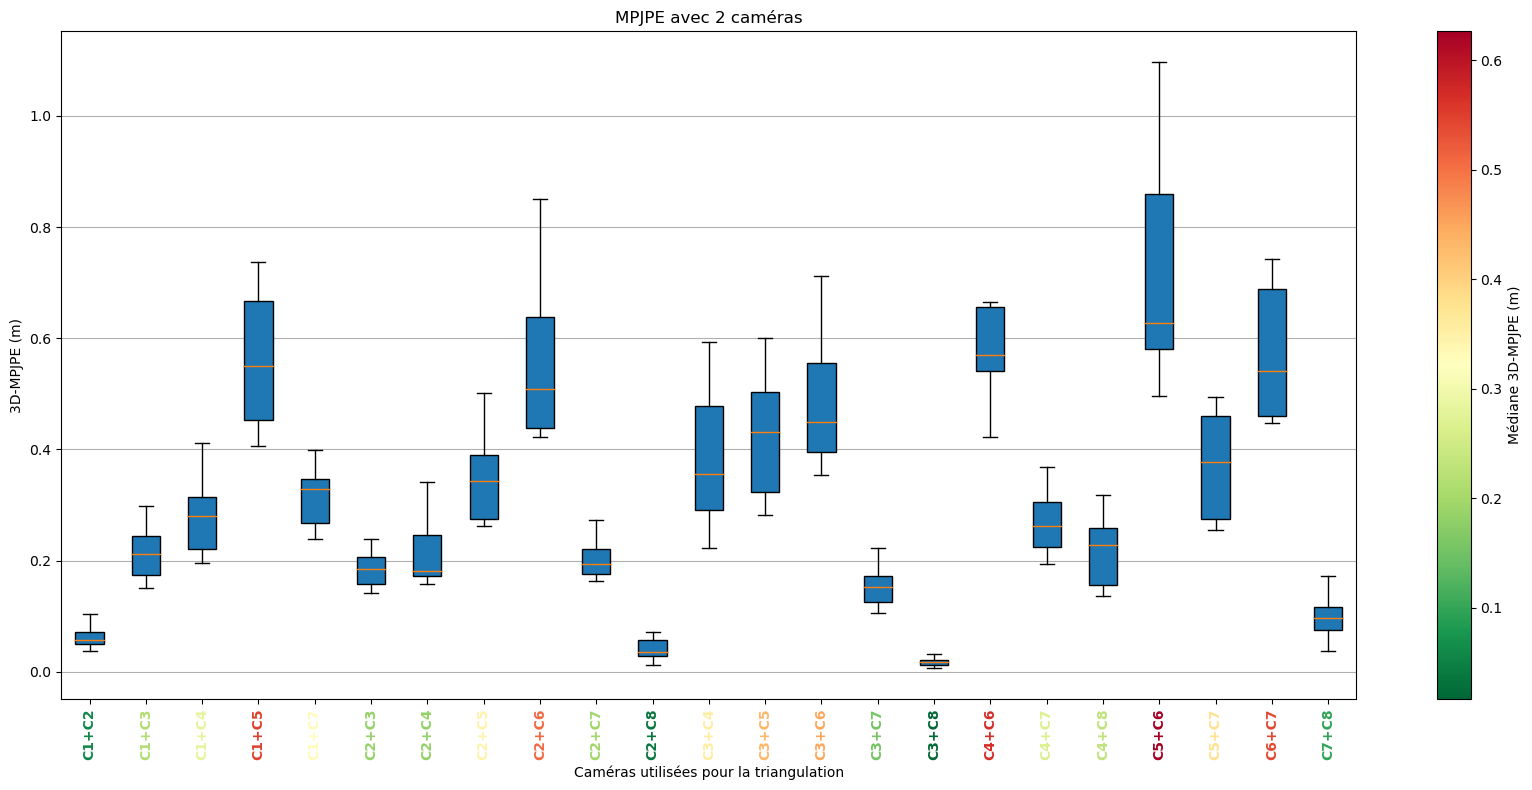

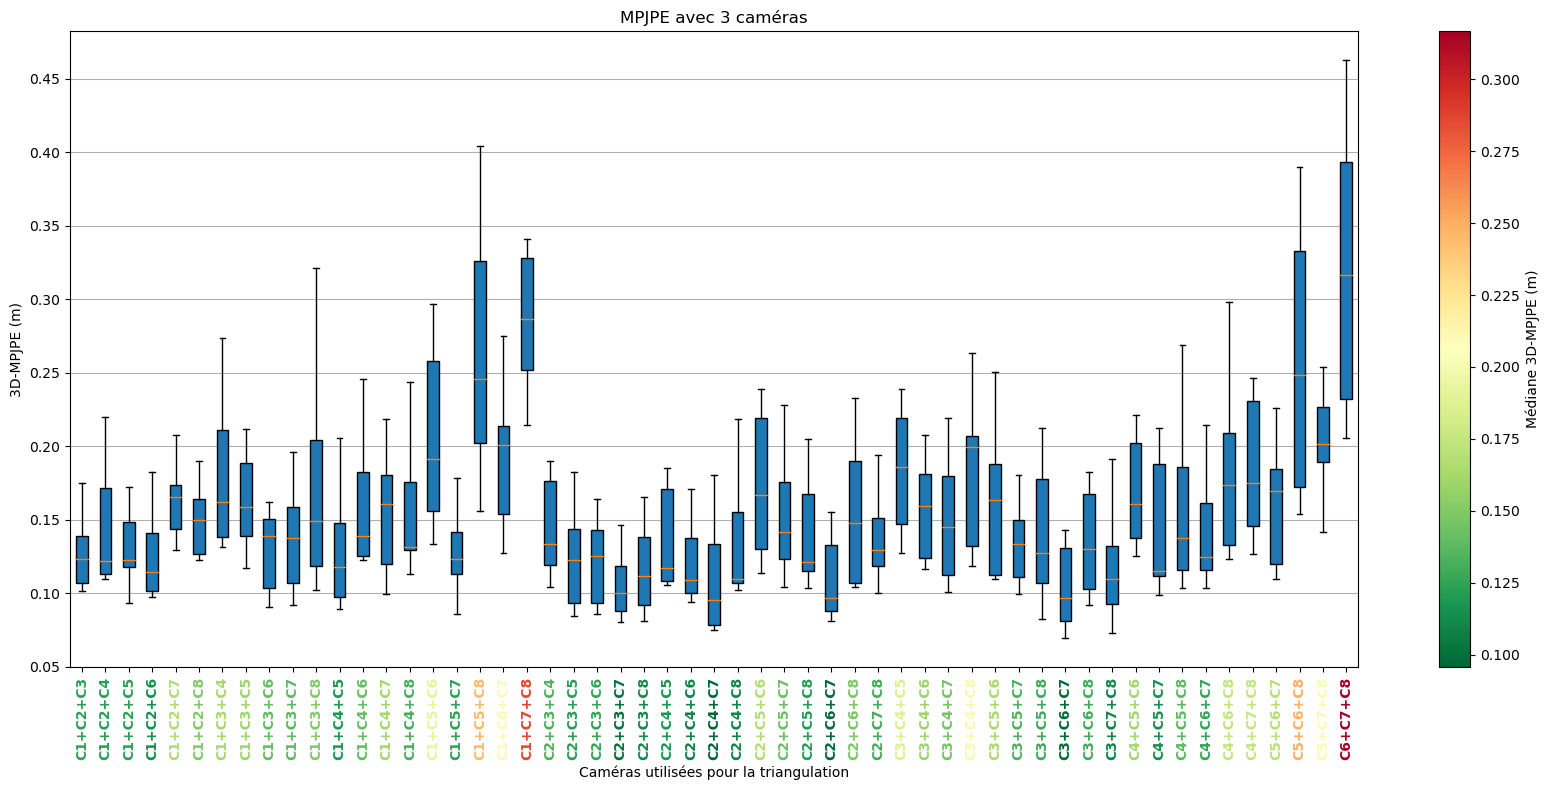

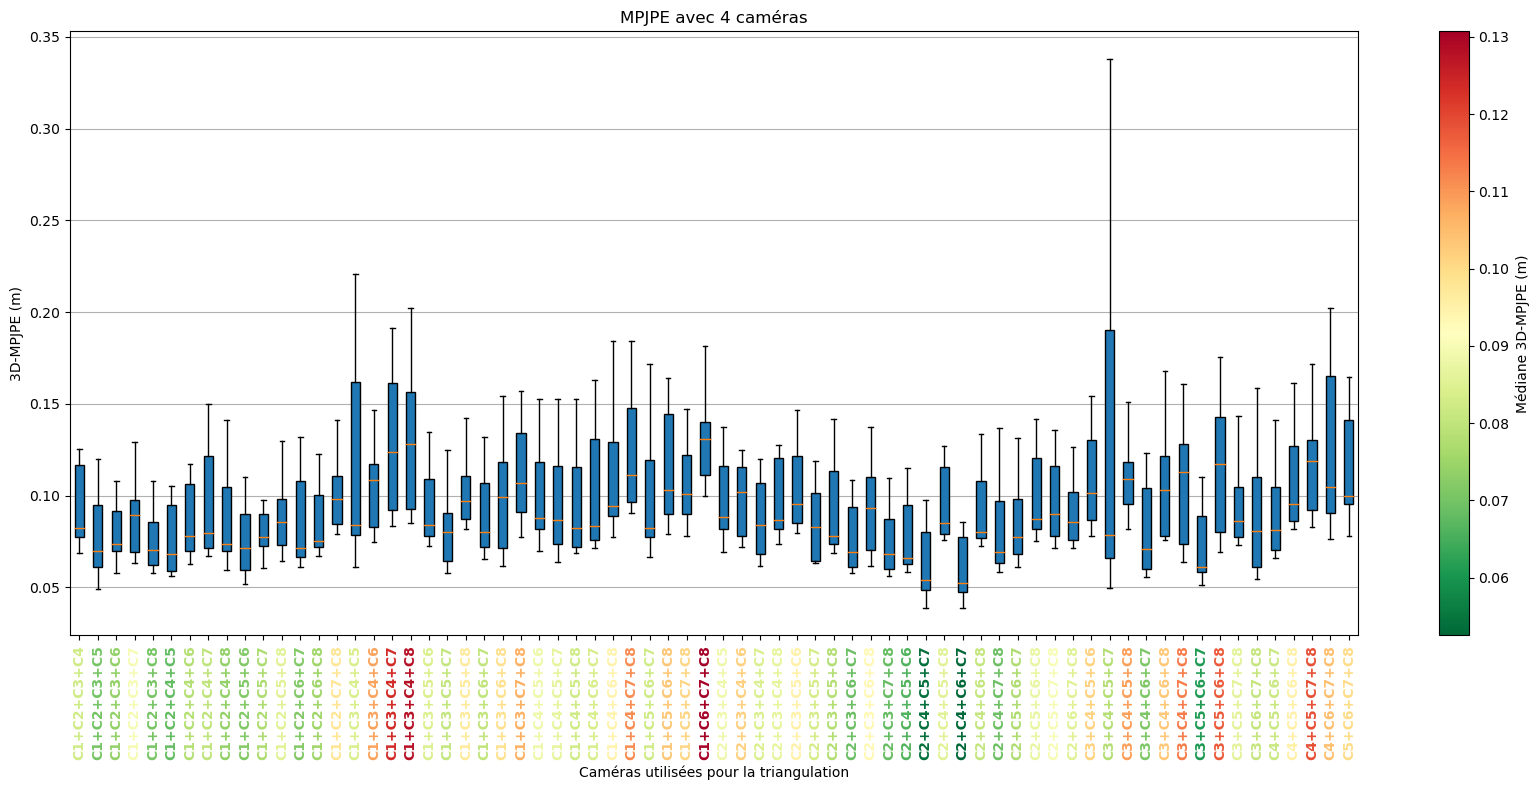

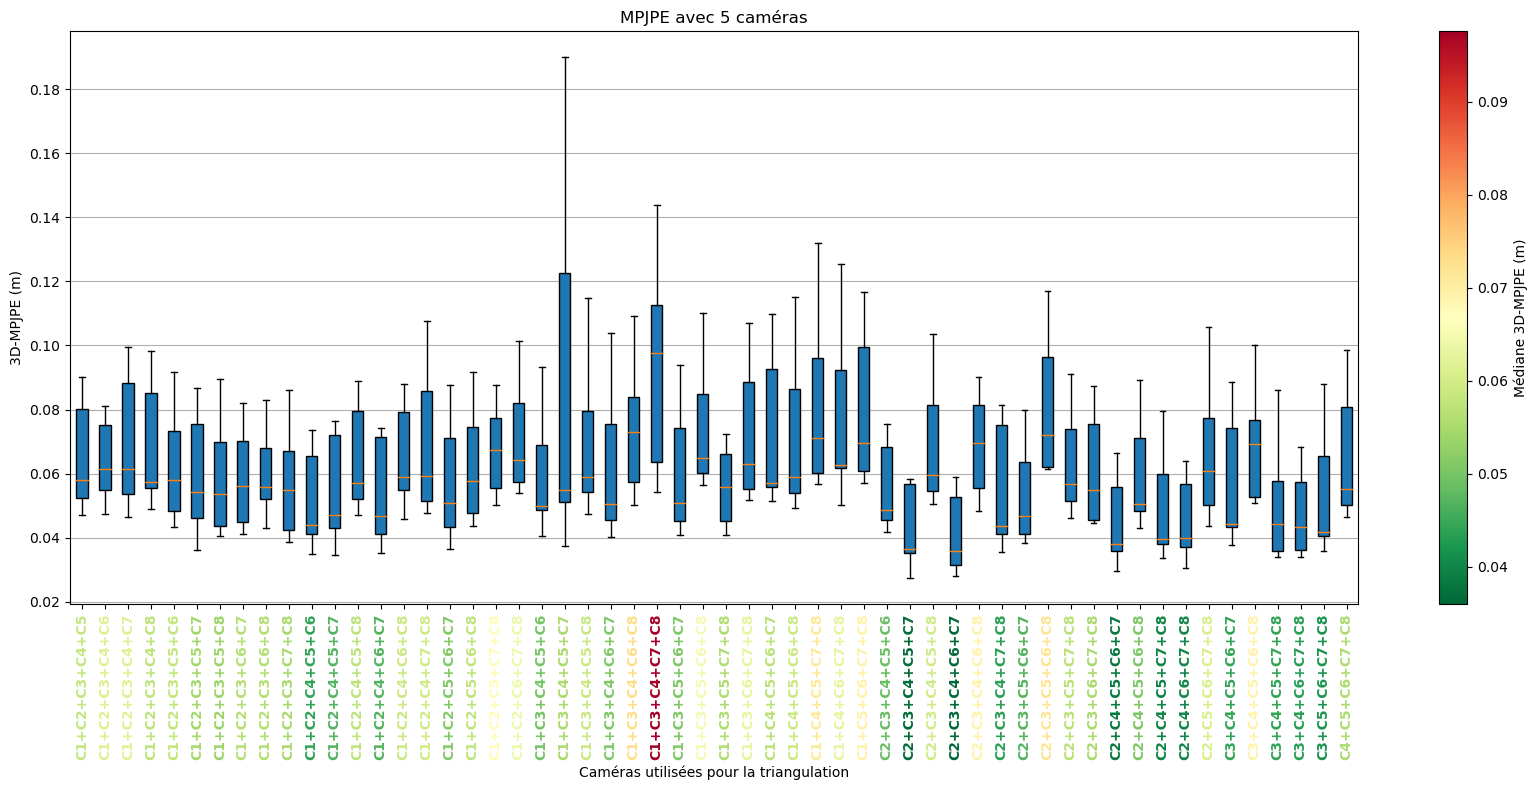

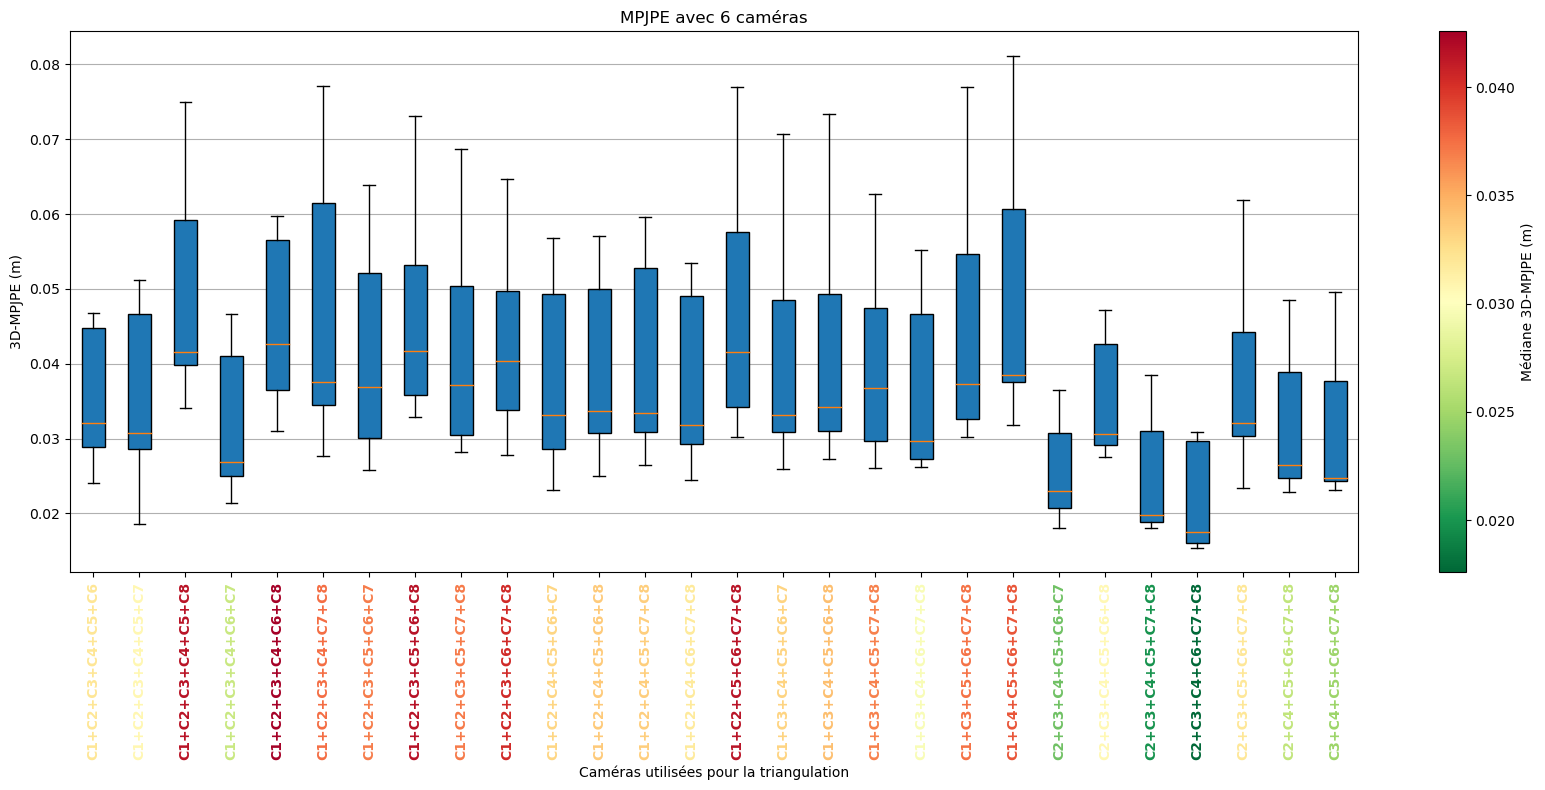

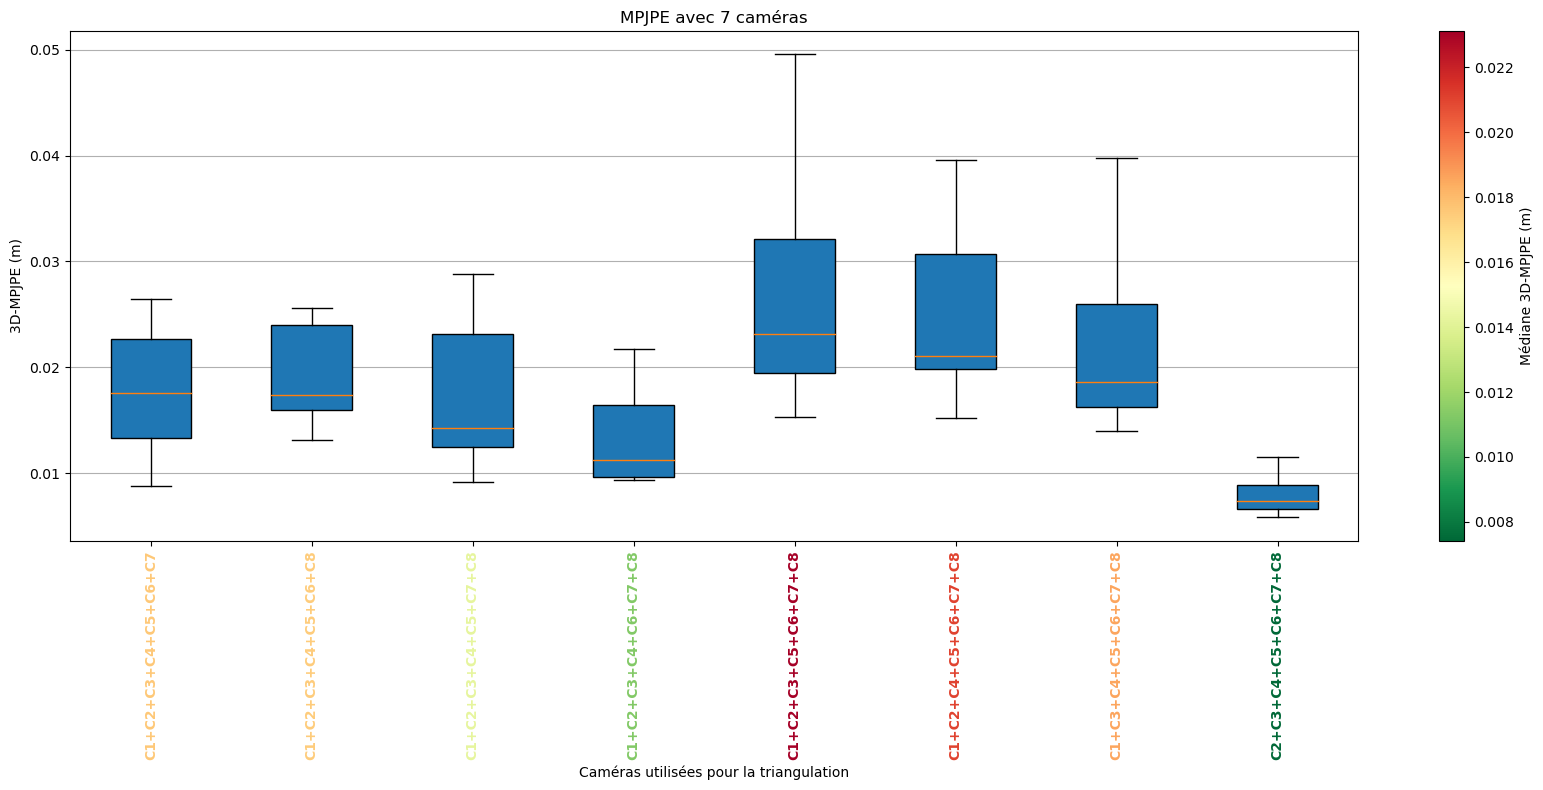

In [8]:
for i in range(2, 8):
    labels = [k for k in mpjpe_per_keypoint_list.keys() if len(k.split('+')) == i]
    valeurs = [np.ravel(v) for k, v in mpjpe_per_keypoint_list.items() if len(k.split('+')) == i]

    # Médianes pour chaque combinaison
    medians = [np.median(v) for v in valeurs]
    means = [np.mean(v) for v in valeurs]

    # Normalisation et colormap
    norm = plt.Normalize(min(medians), max(medians))
    cmap = plt.colormaps['RdYlGn_r']  # rouge = mauvais, vert = bon

    fig, ax = plt.subplots(figsize=(17, 8))
    ax.boxplot(valeurs, labels=labels, patch_artist=True, showfliers=False)

    # Appliquer les couleurs aux labels
    for label, m in zip(ax.get_xticklabels(), medians):
        label.set_color(cmap(norm(m)))
        label.set_fontweight('bold')

    ax.set_xlabel('Caméras utilisées pour la triangulation')
    ax.set_ylabel('3D-MPJPE (m)')
    ax.set_title(f'MPJPE avec {i} caméras')
    plt.setp(ax.get_xticklabels(), rotation=90)
    ax.grid(axis='y')

    # Ajouter la colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # nécessaire pour la colorbar
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Médiane 3D-MPJPE (m)')

    plt.tight_layout()
    plt.savefig(f'/home/lea/trampo/metrics/Pose2Sim_triangulation_figs/vit_3dMPJPE_{i}_cameras_nomean.png')
    plt.show()


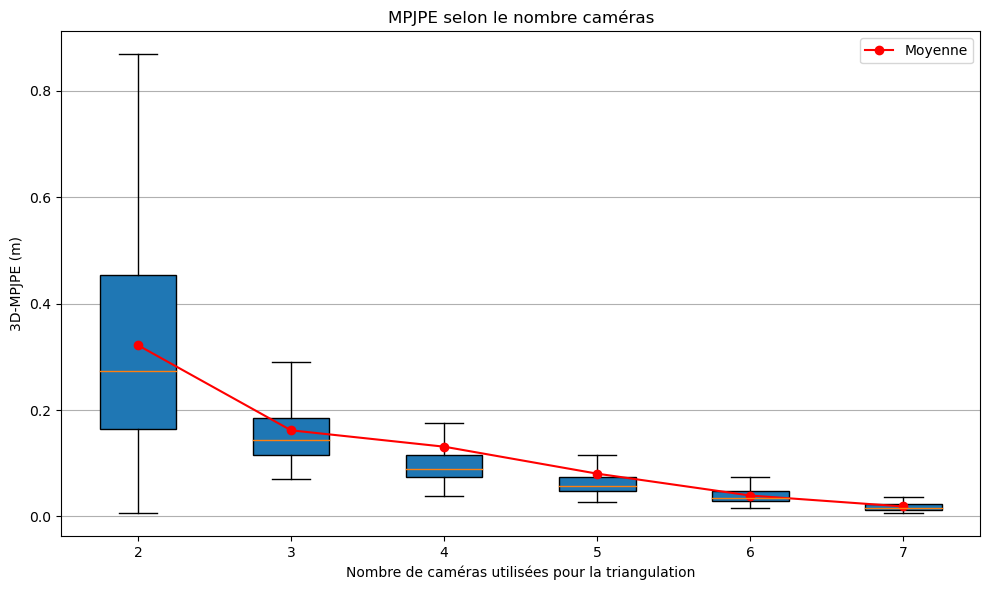

In [9]:
labels = []
valeurs = []
mean_values = []
for i in range(2, 8):
    labels.append(i)
    group_values = [v for k, v in mpjpe_per_keypoint_list.items() if len(k.split('+')) == i]
    group_values = np.ravel(group_values)
    mean_values.append(np.mean(group_values))
    valeurs.append(group_values)

# Boxplot
plt.figure(figsize=(10,6))
plt.boxplot(valeurs, labels=labels, patch_artist=True, showfliers=False)
plt.plot(range(1, len(mean_values) + 1), mean_values, 'r-o', label='Moyenne')

plt.xlabel('Nombre de caméras utilisées pour la triangulation')
plt.ylabel('3D-MPJPE (m)')
plt.title(f'MPJPE selon le nombre caméras')
plt.grid(axis='y')
plt.legend()
plt.tight_layout()

plt.savefig(f'/home/lea/trampo/metrics/Pose2Sim_triangulation_figs/vit_3dMPJPE_N_cameras.png')
plt.show()


In [10]:
def project_points_to_camera(points_3d, K, T, R, im_size=(1920,1080)):
    """
    Projects 3D points to 2D image coordinates using camera intrinsics and extrinsics.

    Args:
        points_3d: (N, 3) array of 3D points.
        K: (3, 3) intrinsic matrix.
        T: (4, 4) extrinsic matrix (camera pose).
        im_size: tuple (width, height), optional. If provided, returns a mask for points inside the image.

    Returns:
        points_2d: (N, 2) projected 2D points.
        valid_mask: (N,) boolean array (only if im_size is given).
    """
    points_3d = np.array(points_3d) # shape (3, N)

    points_3d_r = (R @ points_3d.T).T

    points_3d_h = np.hstack((points_3d_r, np.ones((points_3d_r.shape[0], 1))))
    points_cam = T @ points_3d_h.T # shape (3, N)
    
    points_cam = points_cam[0:3,:] / points_cam[3,:]
    points_2d_h = K @ points_cam  # shape (3, N)

    points_2d = points_2d_h[:2, :] / points_2d_h[2, :]  # normalize
    points_2d = points_2d.T

    if im_size is not None:
        width, height = im_size
        x, y = points_2d[:, 0], points_2d[:, 1]
        valid_mask = (
            (points_cam[2, :] > 0) &  # In front of camera
            (x >= 0) & (x < width) &
            (y >= 0) & (y < height)
        )
        return points_2d, valid_mask

    return points_2d, np.ones(points_2d.shape)  # shape (N, 2)

def load_2d_keypoints(filename):
    # Load JSON file
    with open(filename, "r") as f:
        data = json.load(f)

    if len(data["people"]) > 0:
        coords = []
        conf = []
        for i in range(len(data['people'])):
            keypoints = data["people"][i]["pose_keypoints_2d"]
            keypoints = np.array(keypoints).reshape((-1, 3))

            # Access x, y, and confidence separately if needed
            x_coords = keypoints[:, 0]
            y_coords = keypoints[:, 1]
            confidences = keypoints[:, 2]

            coords.append((x_coords, y_coords))
            conf.append(confidences)

        return coords, conf
    
    return None, None


In [11]:
pose2sim = ['Hip', 'RHip', 'RKnee', 'RAnkle', 'RBigToe', 'RSmallToe', 'RHeel', 'LHip', 'LKnee', 'LAnkle', 'LBigToe', 'LSmallToe', 'LHeel',
            'Neck', 'Nose', 'RShoulder', 'RElbow', 'RWrist', 'LShoulder', 'LElbow', 'LWrist']
humans = ['Nose', 'Neck', 'RShoulder', 'RElbow', 'RWrist', 'LShoulder', 'LElbow', 'LWrist',
          'Hip', 'RHip', 'RKnee', 'RAnkle', 'LHip', 'LKnee', 'LAnkle', 'REye', 'LEye', 'Rear', 'LEar']

vit = ['Nose', 'REye', 'LEye', 'REar', 'LEar', 'RShoulder', 'LShoulder', 'RElbow', 'LElbow', 'RWrist', 'LWrist',
       'RHip', 'LHip', 'RKnee', 'LKnee', 'RAnkle', 'LAnkle']
pose2sim_vit = ['RHip', 'RKnee', 'RAnkle', 'LHip', 'LKnee', 'LAnkle', 'Nose',
                'RShoulder', 'RElbow', 'RWrist', 'LShoulder', 'LElbow', 'LWrist']

# Match Pose2Sim keypoints with 4DHumans
common_indices_humans = [j for j in humans if j in pose2sim]
matching_pose2sim = [pose2sim.index(j) for j in common_indices_humans]
matching_humans = [humans.index(j) for j in common_indices_humans]

common_indices_vit = [j for j in vit if j in pose2sim_vit]
matching_pose2sim_vit = [pose2sim_vit.index(j) for j in common_indices_vit]
matching_vit = [vit.index(j) for j in common_indices_vit]

In [12]:
def get_MPJPE_per_cam(model, cameras, R, K, projMat, matching_2d, matching_3d):
    if model == 'vit':
        source_root = '/home/lea/trampo/Pose2Sim/pose_all_vit'
        triang_root = '/home/lea/trampo/Pose2Sim/pose-3d-vit-multi'
        
    elif model == '4dhumans':
        source_root = '/home/lea/trampo/Pose2Sim/pose_all_4dhumans'
        triang_root = '/home/lea/trampo/Pose2Sim/pose-3d-4DHumans-multi'

    def get_frame_name(model, frame_idx):
            if model == 'vit':
                frame_name = f'frame_{frame_idx:05d}_{frame_idx:06d}'
            elif model == '4dhumans':
                frame_name = f'frame_{frame_idx:06d}'
            return frame_name

    sequence_names = set(f.split('-')[0] for f in os.listdir(source_root))
    dist_per_cam = {}

    for cam_idx in range(8):
        cam_name = cameras[cam_idx]
        dist_per_cam.update({cam_name: {}})
        print(f'--- C{cam_idx+1} ---')
        
        for cam_combination in itertools.combinations(enumerate(cameras), 4):
            cam_indices, cam_names = zip(*cam_combination)
            if cam_idx in cam_indices:
                continue
            cam_label = '+'.join(f"C{idx+1}" for idx in cam_indices)  # Label like C1+C3+C5
            dist_per_cam[cam_name].update({cam_label:[]})
            dist = []
            
            # keypoints 2d cam i
            for seq in sorted(sequence_names):
                folder_name = f"{seq}-{cam_name}_json"
                src_path = os.path.join(source_root, folder_name)

            # keypoints 3d 4 cams
            triang_path = os.path.join(triang_root, seq, cam_label, f'{seq}.trc')
            triang_points, frame_numbers = extract_coordinates(triang_path)

            # frames loop
            for frame_idx in range(0, len(os.listdir(src_path))):
                # 2d
                frame_name = get_frame_name(model, frame_idx)
                vit_pts, _ = load_2d_keypoints(f'{src_path}/{frame_name}.json')
                
                if vit_pts is not None:
                    vit_pts = np.array(vit_pts)
                    n_detections = vit_pts.shape[0]
                    vit_pts = vit_pts.reshape((n_detections, 2, -1))
                    vit_pts = vit_pts[:, :, matching_2d]
                else:
                    continue
                
                # 3d
                coords = triang_points[np.where(frame_numbers == frame_idx)].reshape((-1, 3))
                if len(coords) > 0:
                    coords = coords[matching_3d]
                else:
                    continue

                # reproj 3d -> 2d cam i
                reproj, _ = project_points_to_camera(coords*1000, K[cam_idx], projMat[cam_idx], R)

                # OPTIONAL : visualize detections and reprojection on images
                """ fig, ax = plt.subplots(figsize=(19,10))
                print(seq, frame_idx, cam_name)
                img = mpimg.imread(f'/mnt/D494C4CF94C4B4F0/Trampoline_avril2025/Images_trampo_avril2025/20250429/{seq}-{cameras[cam_idx]}/frame_{frame_idx:05d}.png')
                ax.imshow(img)
                plt.scatter(*reproj.T, label='reprojection')
                draw_skeleton(reproj, 'blue', ax, model)
                for i in range(vit_pts.shape[0]):
                    plt.scatter(*vit_pts[i], label=f'detection {i+1}')
                    draw_skeleton(vit_pts[i].T, 'orange', ax, model)
                #ax.axis('equal')
                ax.set_xlim(0, 1920)
                ax.set_ylim(0, 1080)
                plt.legend()
                plt.show() """
                
                # distance 2d
                min_dist = np.full(reproj.shape[0], np.inf)
                for j in range(vit_pts.shape[0]):
                    vit_reshaped = vit_pts[j].T
                    dist_j = np.linalg.norm(reproj - vit_reshaped, axis=1)
                    if np.mean(dist_j) < np.mean(min_dist):
                        min_dist = dist_j
                dist.append(min_dist)
            
            dist_per_cam[cam_name][cam_label] = dist

    return dist_per_cam

def plot_MPJPE_per_cam(MPJPE_per_cam, model, showNaN=False, ylim=False):
    n_best, n_worst = 4, 4

    for cam_label, dists in MPJPE_per_cam.items():
        labels = list(dists.keys())
        valeurs_list = list(dists.values())
        max_len = max(len(v) for v in valeurs_list)
        size = np.array(valeurs_list[0]).shape[-1]

        # Remplissage des valeurs avec NaN
        valeurs = np.full((len(valeurs_list), max_len * size), np.nan)
        for i, arr in enumerate(valeurs_list):
            r_arr = np.ravel(arr)
            valeurs[i, :len(r_arr)] = r_arr
        valeurs_sans_nan = [row[~np.isnan(row)] for row in valeurs]

        # Métriques
        nan_counts = np.isnan(valeurs).sum(axis=1)
        error_medians = np.nanmedian(valeurs, axis=1)
        error_q1 = np.nanquantile(valeurs, 0.25, axis=1)
        error_q3 = np.nanquantile(valeurs, 0.75, axis=1)
        error_maxiq = error_q3 + 1.5*(error_q3 - error_q1)

        if nan_counts.max() == 0:
            showNaN = False

        # --- Score combiné normalisé ---
        score_combined = error_medians / error_medians.max() + nan_counts / nan_counts.max() if showNaN else error_medians / error_medians.max()
        best_indices = np.argsort(score_combined)[:n_best]
        worst_indices = np.argsort(nan_counts)[-n_worst:]  # toujours basé sur NaN

        # --- Création des axes ---
        fig, ax1 = plt.subplots(figsize=(15, 8))
        
        # Boxplot des erreurs (orange)
        bp = ax1.boxplot(valeurs_sans_nan, positions=np.arange(len(labels)),
                        patch_artist=True, showfliers=False)
        for patch in bp['boxes']:
            patch.set_facecolor('tab:blue')
        ax1.set_ylabel('Erreur 2D-MPJPE (px)', color='tab:blue', fontweight='bold')

        if not ylim:
            ax1.set_ylim(0, max(error_maxiq) * 1.05)
        else:
            ax1.set_ylim(0, ylim)

        if showNaN:
            ax2 = ax1.twinx()
            # Barres du nombre de NaN (bleu)
            bars = ax2.bar(np.arange(len(labels)), nan_counts, alpha=0.4,
                        color='skyblue', width=0.6)
            ax2.set_ylabel('Nombre total de points manquants (NaN)', color='skyblue', fontweight='bold')
            ax2.set_ylim(0, max(nan_counts) * 1.05)

            # --- Légende partagée ---
            legend_elements = [Patch(facecolor='tab:blue', label='Erreur 2D-MPJPE (px)'),
                            Patch(facecolor='skyblue', alpha=0.4, label='Nombre total de NaN')]
            ax1.legend(handles=legend_elements, loc='upper left')

        # --- Coloration des labels ---
        ax1.set_xticks(np.arange(len(labels)))
        ax1.set_xticklabels(labels, rotation=90)
        xticklabels = ax1.get_xticklabels()
        for idx in worst_indices:
            xticklabels[idx].set_color('red')
            xticklabels[idx].set_fontweight('bold')
        for idx in best_indices:
            xticklabels[idx].set_color('green')
            xticklabels[idx].set_fontweight('bold')

        # --- Grilles et titre ---
        ax1.grid(axis='y', linestyle='--', alpha=0.7)
        ax1.set_title(f'Erreur et NaN post triangulation sur la {cam_label}')

        plt.tight_layout()
        plt.savefig(f'/home/lea/trampo/metrics/Pose2Sim_triangulation_figs/{model}_reproj_NaN__filtCoM_{cam_label}.png')
        plt.show()

--- C1 ---
--- C2 ---
--- C3 ---
--- C4 ---
--- C5 ---
--- C6 ---
--- C7 ---
--- C8 ---


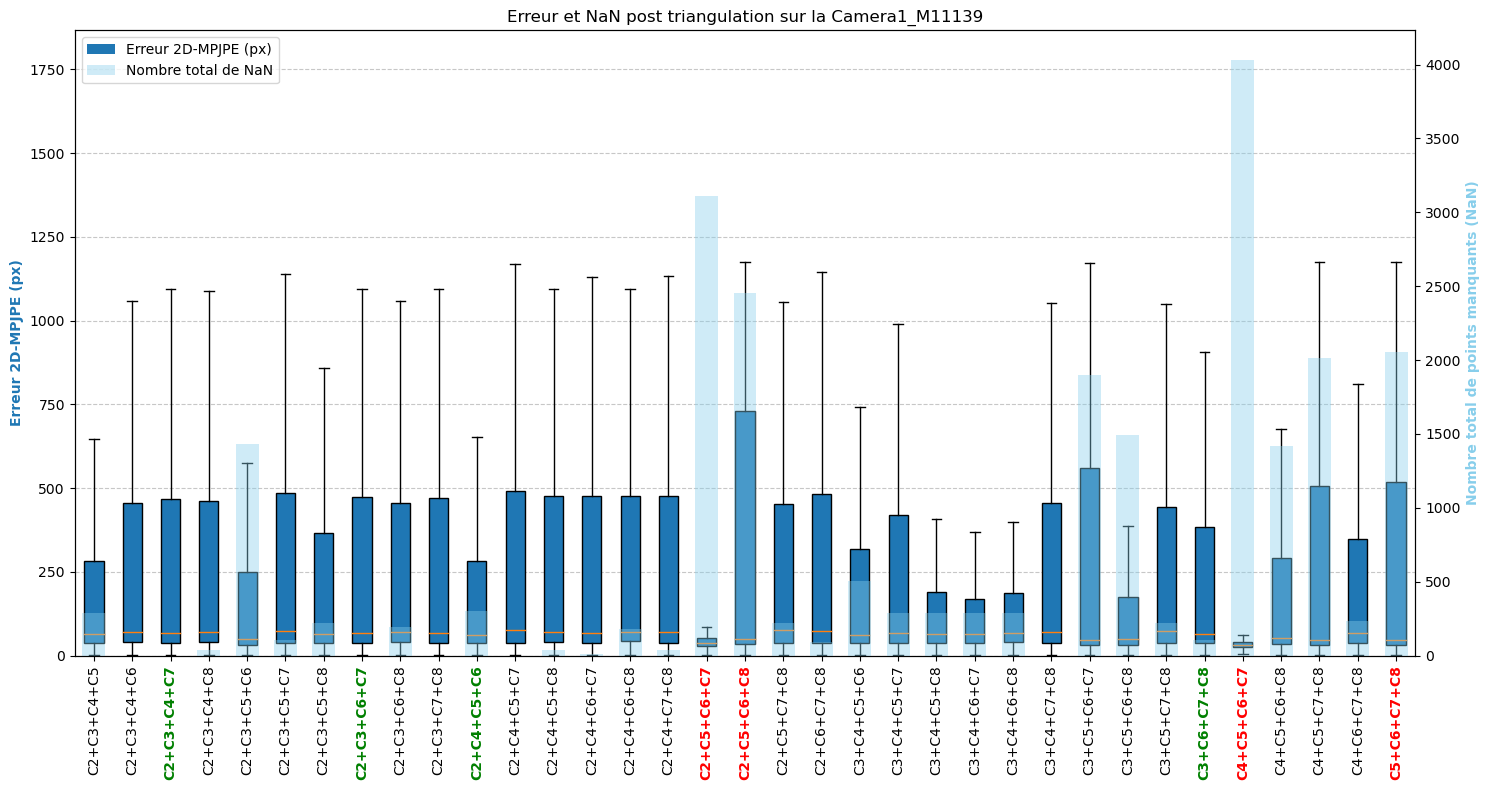

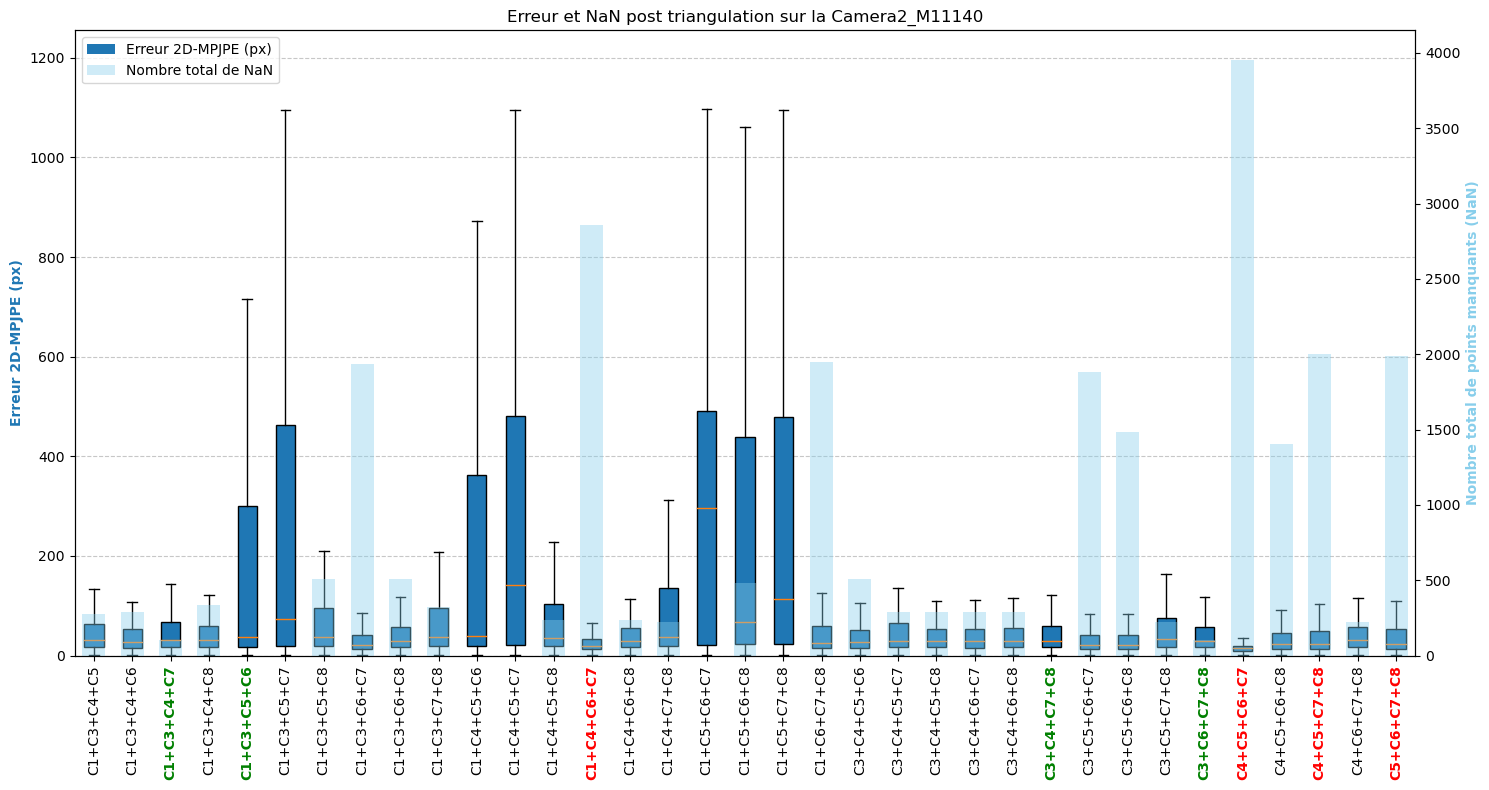

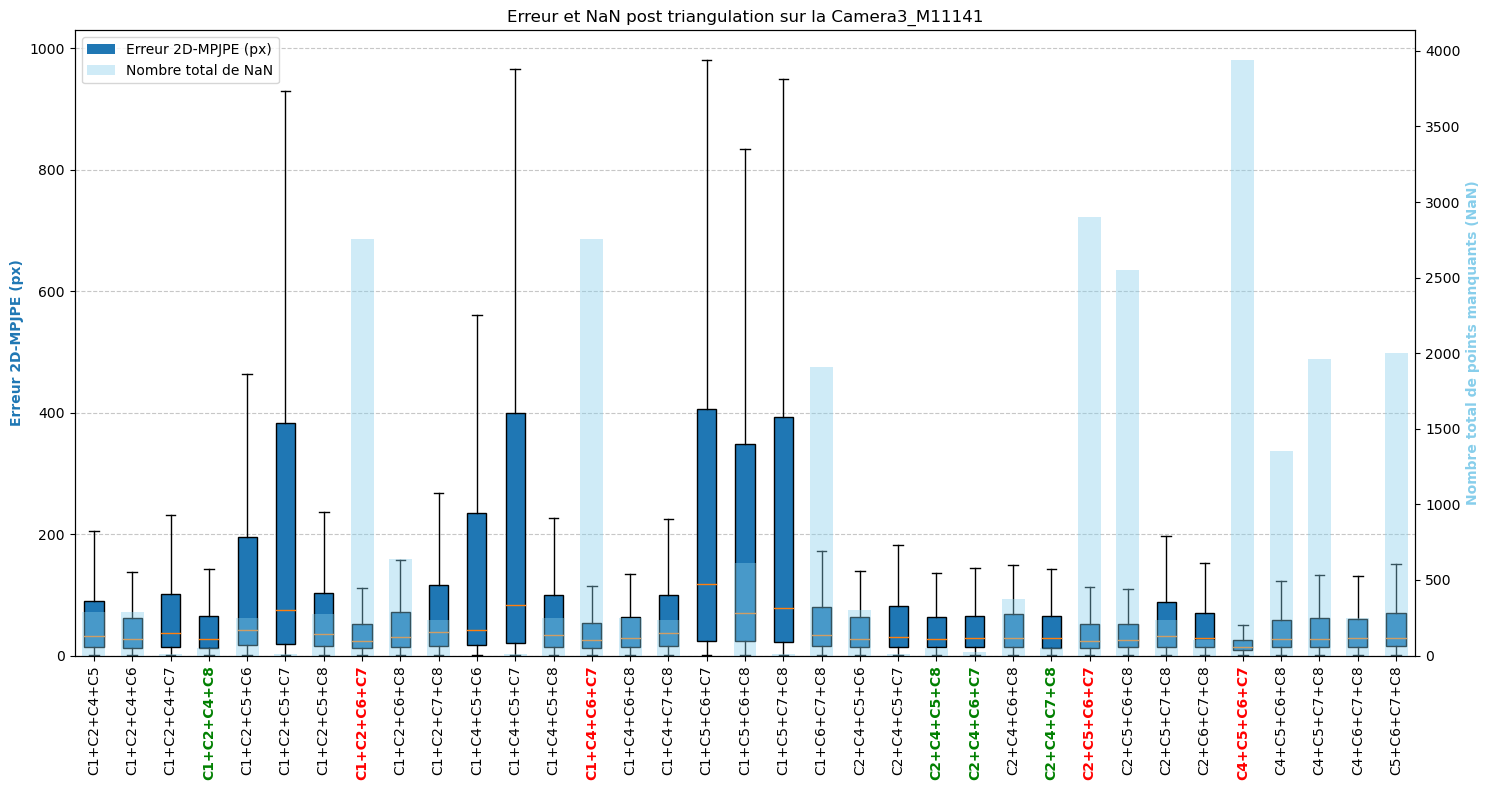

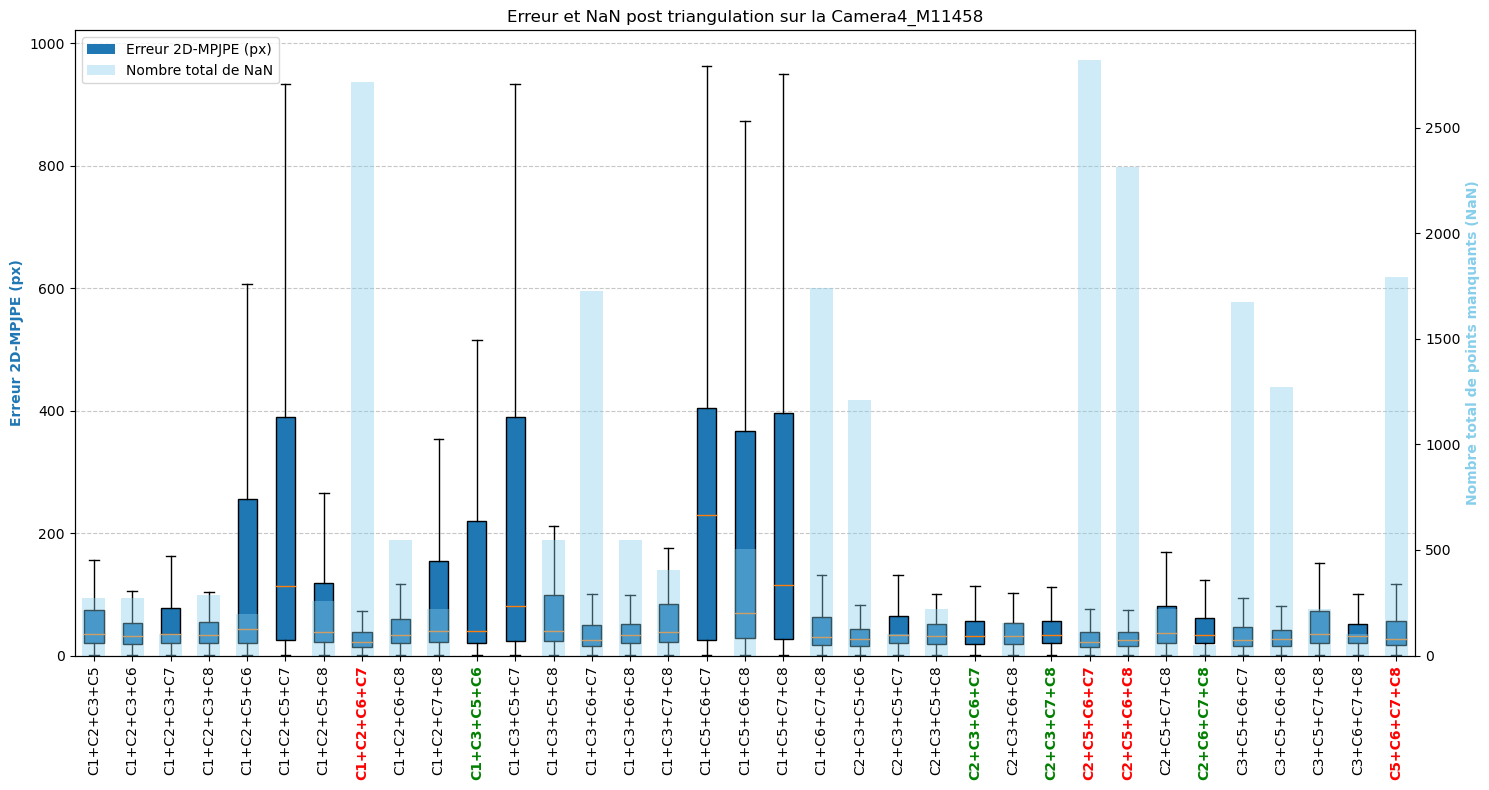

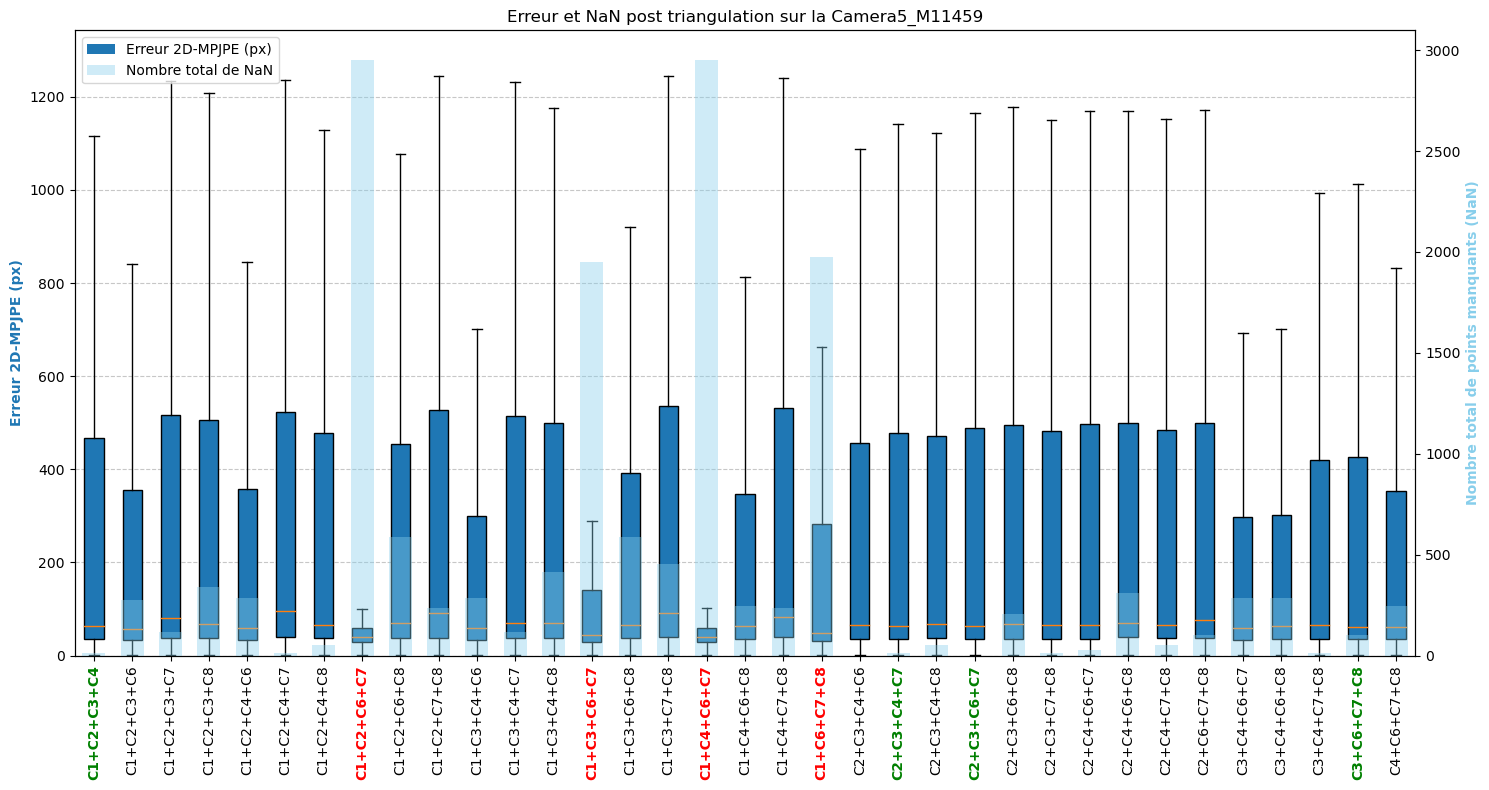

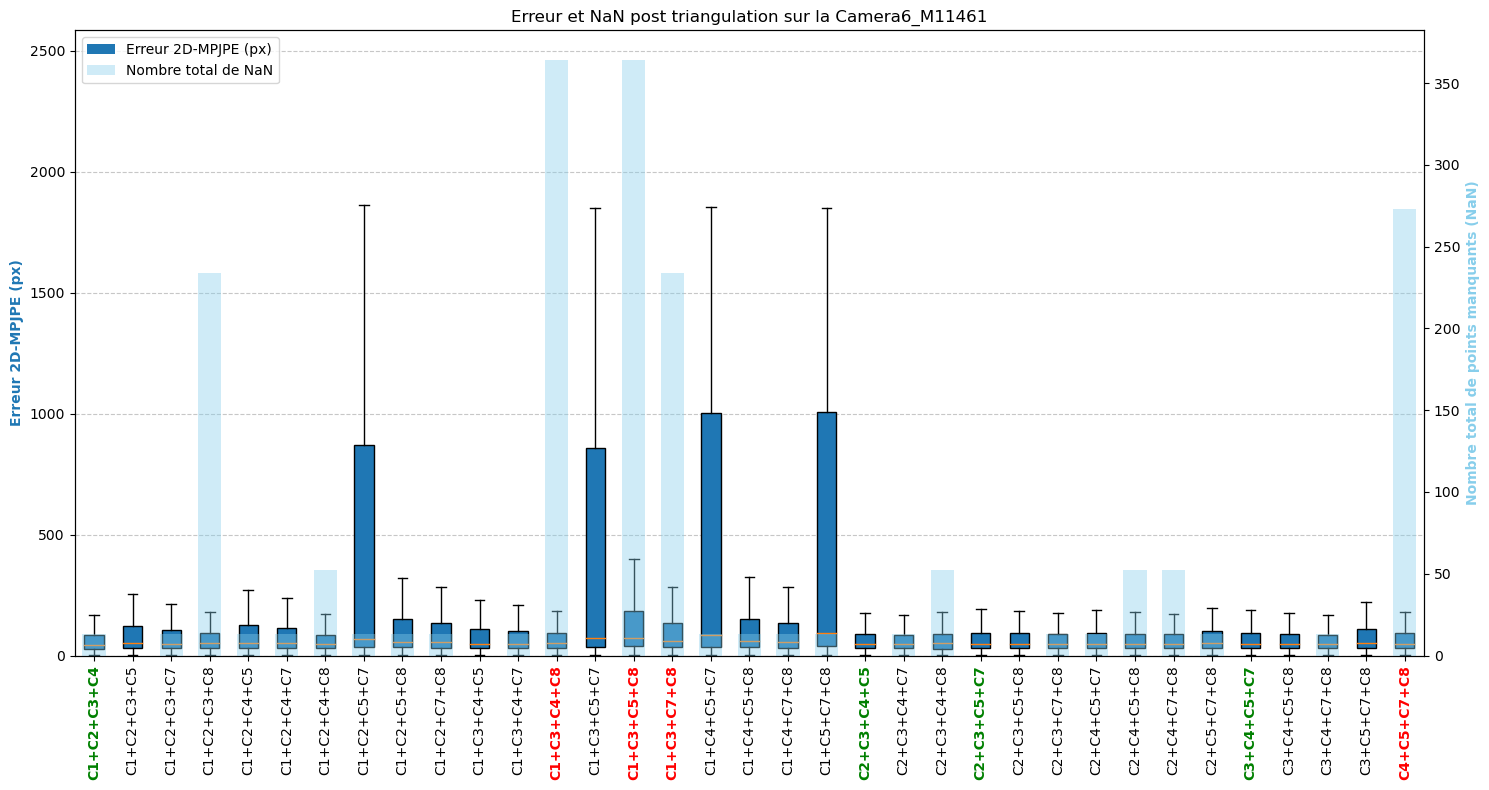

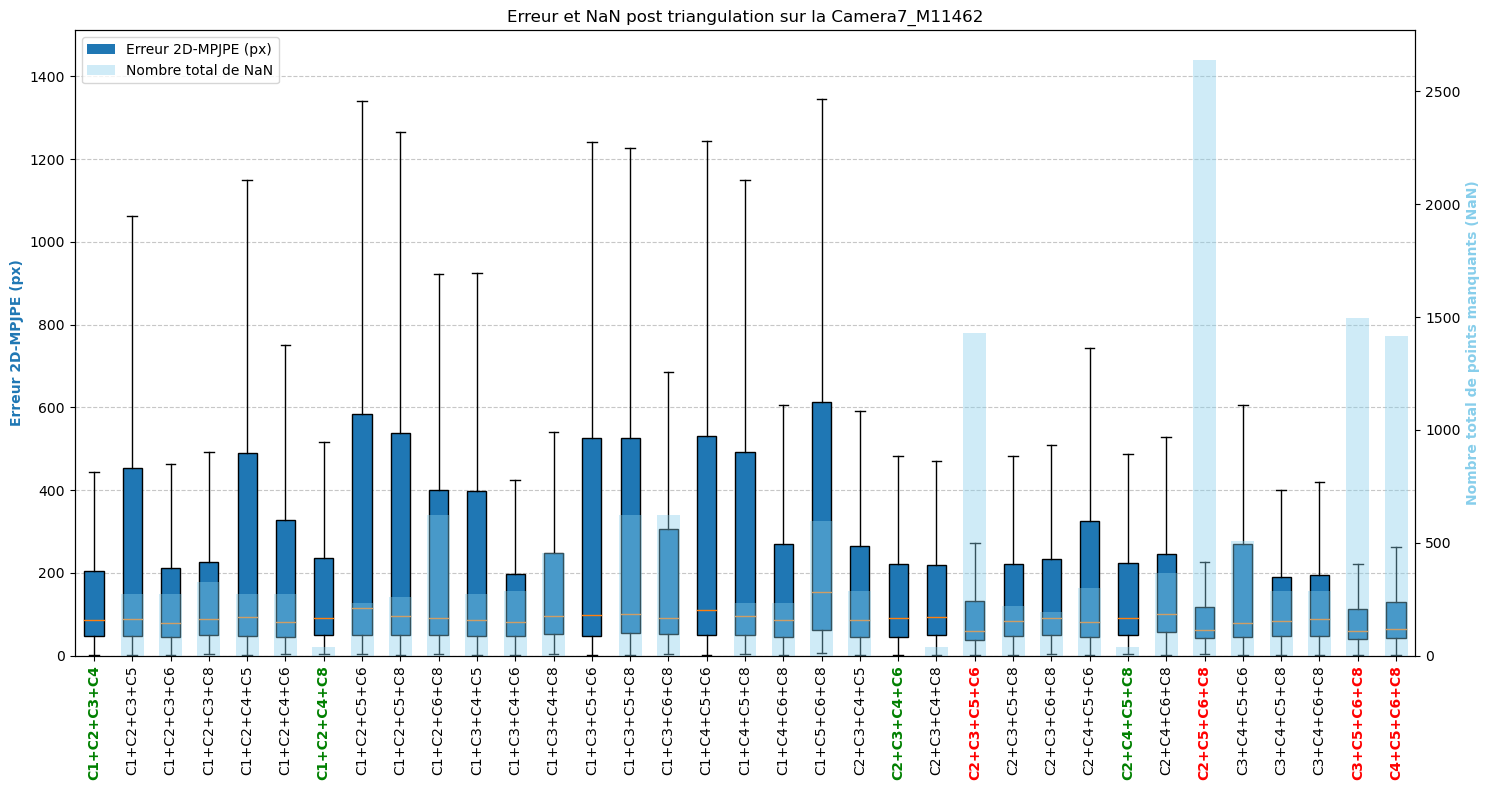

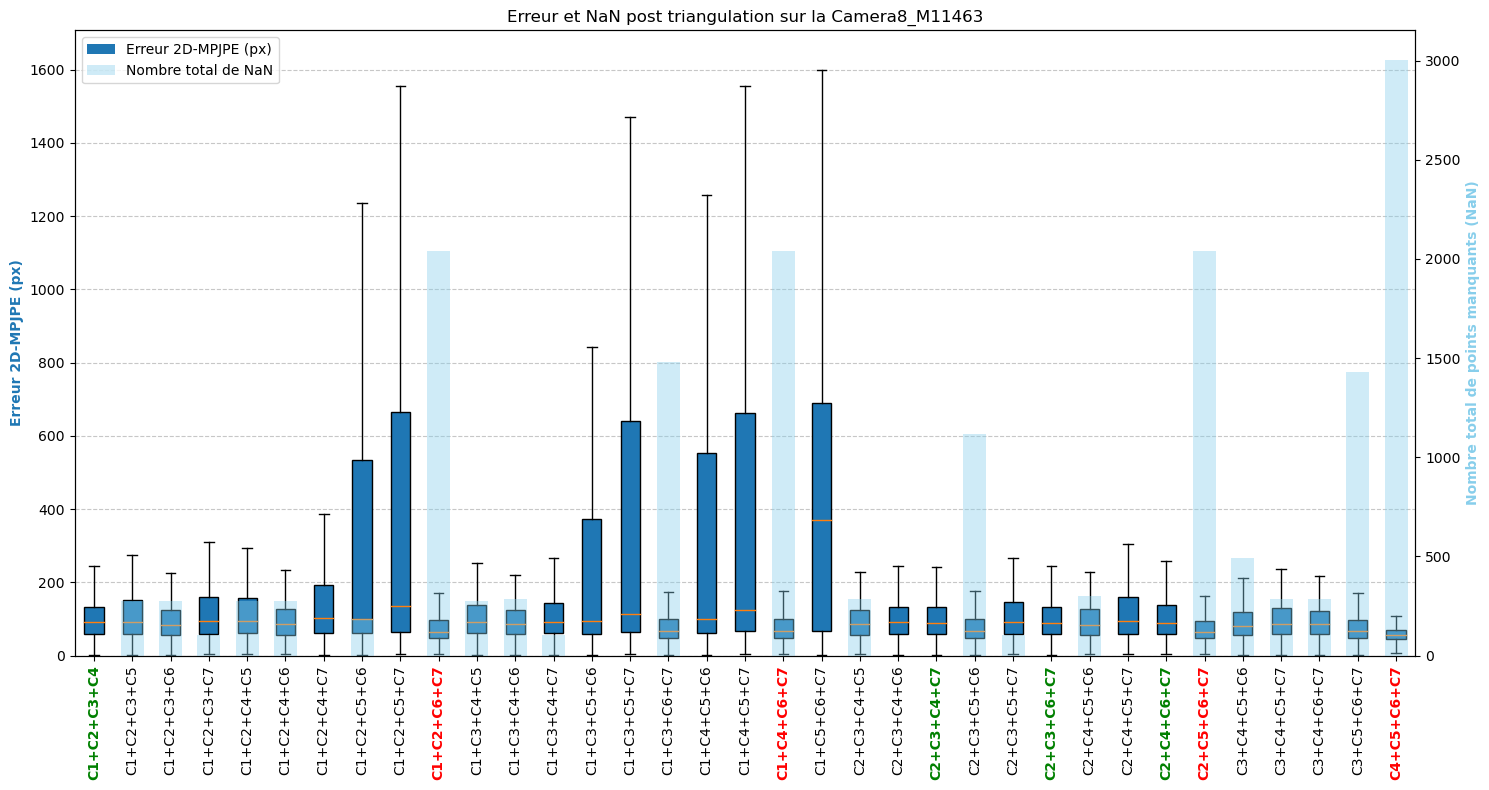

In [13]:
model = 'vit'

matching_2d = matching_vit
matching_3d = matching_pose2sim_vit

cameras = ['Camera1_M11139', 'Camera2_M11140', 'Camera3_M11141',
           'Camera4_M11458', 'Camera5_M11459', 'Camera6_M11461',
           'Camera7_M11462', 'Camera8_M11463']

# define Rotation for Pose2Sim to World
R = np.array([[0, 0, 1],
              [-1, 0, 0],
              [0, 1, 0]])

dist_per_cam = get_MPJPE_per_cam(model, cameras, R, K, projMat, matching_2d, matching_3d)

plot_MPJPE_per_cam(dist_per_cam, model, showNaN=True)

In [14]:
def get_stats(values):
    arr = np.array(values)
    return {
        "moyenne": np.mean(arr),
        "médiane": np.median(arr),
        "écart_type": np.std(arr, ddof=1),  # écart-type échantillon
        "q1": np.percentile(arr, 25),
        "q3": np.percentile(arr, 75)
    }

def get_all_stats(data):
    # --- 1) Statistiques par combinaison ---
    stats_par_combinaison = {cam: {comb: get_stats(vals) for comb, vals in comb_dict.items()}
                            for cam, comb_dict in data.items()}
    # --- 2) Statistiques par caméra ---
    stats_par_camera = {}
    for cam, comb_dict in data.items():
        toutes_valeurs = np.concatenate(list(comb_dict.values()))
        stats_par_camera[cam] = get_stats(toutes_valeurs)

    # --- 3) Statistiques globales ---
    toutes_valeurs_global = np.concatenate([vals for comb_dict in data.values() for vals in comb_dict.values()])
    stats_globales = get_stats(toutes_valeurs_global)

    # Affichage
    print("\n--- Stats par combinaison ---")
    for cam, combs in stats_par_combinaison.items():
        print(cam)
        for comb, stats in combs.items():
            print(f"  {comb}: {stats}")

    print("\n--- Stats par caméra ---")
    for cam, stats in stats_par_camera.items():
        print(f"{cam}: {stats}")

    print("\n--- Stats globales ---")
    print(stats_globales)

get_all_stats(dist_per_cam)


--- Stats par combinaison ---
Camera1_M11139
  C2+C3+C4+C5: {'moyenne': 222.41456172757037, 'médiane': 65.28853114351291, 'écart_type': 302.9118385375196, 'q1': 37.03167103082102, 'q3': 281.59132234365705}
  C2+C3+C4+C6: {'moyenne': 234.31192693495345, 'médiane': 70.3820528620252, 'écart_type': 300.758584991425, 'q1': 39.088230745963166, 'q3': 455.9252060739901}
  C2+C3+C4+C7: {'moyenne': 234.28754723054547, 'médiane': 67.59994920984882, 'écart_type': 302.26262853111456, 'q1': 37.134935332078214, 'q3': 468.0032629604931}
  C2+C3+C4+C8: {'moyenne': 236.92156719461474, 'médiane': 71.70938611829935, 'écart_type': 300.80988676757715, 'q1': 40.65007172790136, 'q3': 461.8397578814855}
  C2+C3+C5+C6: {'moyenne': 232.86512549943123, 'médiane': 48.13505941285199, 'écart_type': 335.80941062216374, 'q1': 31.02250865440656, 'q3': 249.12262693806412}
  C2+C3+C5+C7: {'moyenne': 246.99949900450963, 'médiane': 73.75300551978523, 'écart_type': 300.7536544068249, 'q1': 37.37055333923382, 'q3': 485.9377

### Filter detections based on CM to compute MPJPE between same person

In [15]:
from compute_CoM import CoM

def get_MPJPE_per_cam_CoM(model, cameras, R, K, projMat, matching_2d, matching_3d):
    if model == 'vit':
        source_root = '/home/lea/trampo/Pose2Sim/pose_all_vit'
        triang_root = '/home/lea/trampo/Pose2Sim/pose-3d-vit-multi'
        
    elif model == '4dhumans':
        source_root = '/home/lea/trampo/Pose2Sim/pose_all_4dhumans'
        triang_root = '/home/lea/trampo/Pose2Sim/pose-3d-4DHumans-multi'

    def get_frame_name(model, frame_idx):
            if model == 'vit':
                frame_name = f'frame_{frame_idx:05d}_{frame_idx:06d}'
            elif model == '4dhumans':
                frame_name = f'frame_{frame_idx:06d}'
            return frame_name

    sequence_names = set(f.split('-')[0] for f in os.listdir(source_root))
    dist_per_cam = {}

    for cam_idx in range(8):
        cam_name = cameras[cam_idx]
        dist_per_cam.update({cam_name: {}})
        print(f'--- C{cam_idx+1} ---')
        
        for cam_combination in itertools.combinations(enumerate(cameras), 4):
            cam_indices, cam_names = zip(*cam_combination)
            if cam_idx in cam_indices:
                continue
            cam_label = '+'.join(f"C{idx+1}" for idx in cam_indices)  # Label like C1+C3+C5
            dist_per_cam[cam_name].update({cam_label:[]})
            dist = []
            
            # keypoints 2d cam i
            for seq in sorted(sequence_names):
                folder_name = f"{seq}-{cam_name}_json"
                src_path = os.path.join(source_root, folder_name)

            # keypoints 3d 4 cams
            triang_path = os.path.join(triang_root, seq, cam_label, f'{seq}.trc')
            triang_points, frame_numbers = extract_coordinates(triang_path)

            # frames loop
            for frame_idx in range(0, len(os.listdir(src_path))):
                # 2d
                frame_name = get_frame_name(model, frame_idx)
                vit_pts, _ = load_2d_keypoints(f'{src_path}/{frame_name}.json')
                
                if vit_pts is not None:
                    vit_pts = np.array(vit_pts)
                    n_detections = vit_pts.shape[0]
                    vit_pts = vit_pts.reshape((n_detections, 2, -1))
                    vit_pts = vit_pts[:, :, matching_2d]
                else:
                    continue
                
                # 3d
                coords = triang_points[np.where(frame_numbers == frame_idx)].reshape((-1, 3))
                if len(coords) > 0:
                    coords = coords[matching_3d]
                else:
                    continue

                # reproj 3d -> 2d cam i
                reproj, _ = project_points_to_camera(coords*1000, K[cam_idx], projMat[cam_idx], R)

                # OPTIONAL : visualize detections and reprojection on images
                """ fig, ax = plt.subplots(figsize=(19,10))
                print(seq, frame_idx, cam_name)
                img = mpimg.imread(f'/mnt/D494C4CF94C4B4F0/Trampoline_avril2025/Images_trampo_avril2025/20250429/{seq}-{cameras[cam_idx]}/frame_{frame_idx:05d}.png')
                ax.imshow(img)
                plt.scatter(*reproj.T, label='reprojection')
                draw_skeleton(reproj, 'blue', ax, model)
                for i in range(vit_pts.shape[0]):
                    plt.scatter(*vit_pts[i], label=f'detection {i+1}')
                    draw_skeleton(vit_pts[i].T, 'orange', ax, model)
                #ax.axis('equal')
                ax.set_xlim(0, 1920)
                ax.set_ylim(0, 1080)
                plt.legend()
                plt.show() """
                
                # distance 2d + filter on CoM position
                com_obj = CoM('women', 13)
                min_dist = np.full(reproj.shape[0], np.inf)
                
                for j in range(vit_pts.shape[0]):
                    vit_reshaped = vit_pts[j].T
                    dist_j = np.linalg.norm(reproj - vit_reshaped, axis=1)

                    com_reproj = com_obj.compute_global_cm(reproj)
                    com_detect = com_obj.compute_global_cm(vit_reshaped)

                    if np.linalg.norm(com_reproj - com_detect) < 200 and np.mean(dist_j) < np.mean(min_dist):
                        min_dist = dist_j

                if min_dist.sum() != np.inf:        
                    dist.append(min_dist)
            
            dist_per_cam[cam_name][cam_label] = dist

    return dist_per_cam


--- C1 ---
--- C2 ---
--- C3 ---
--- C4 ---
--- C5 ---
--- C6 ---
--- C7 ---
--- C8 ---


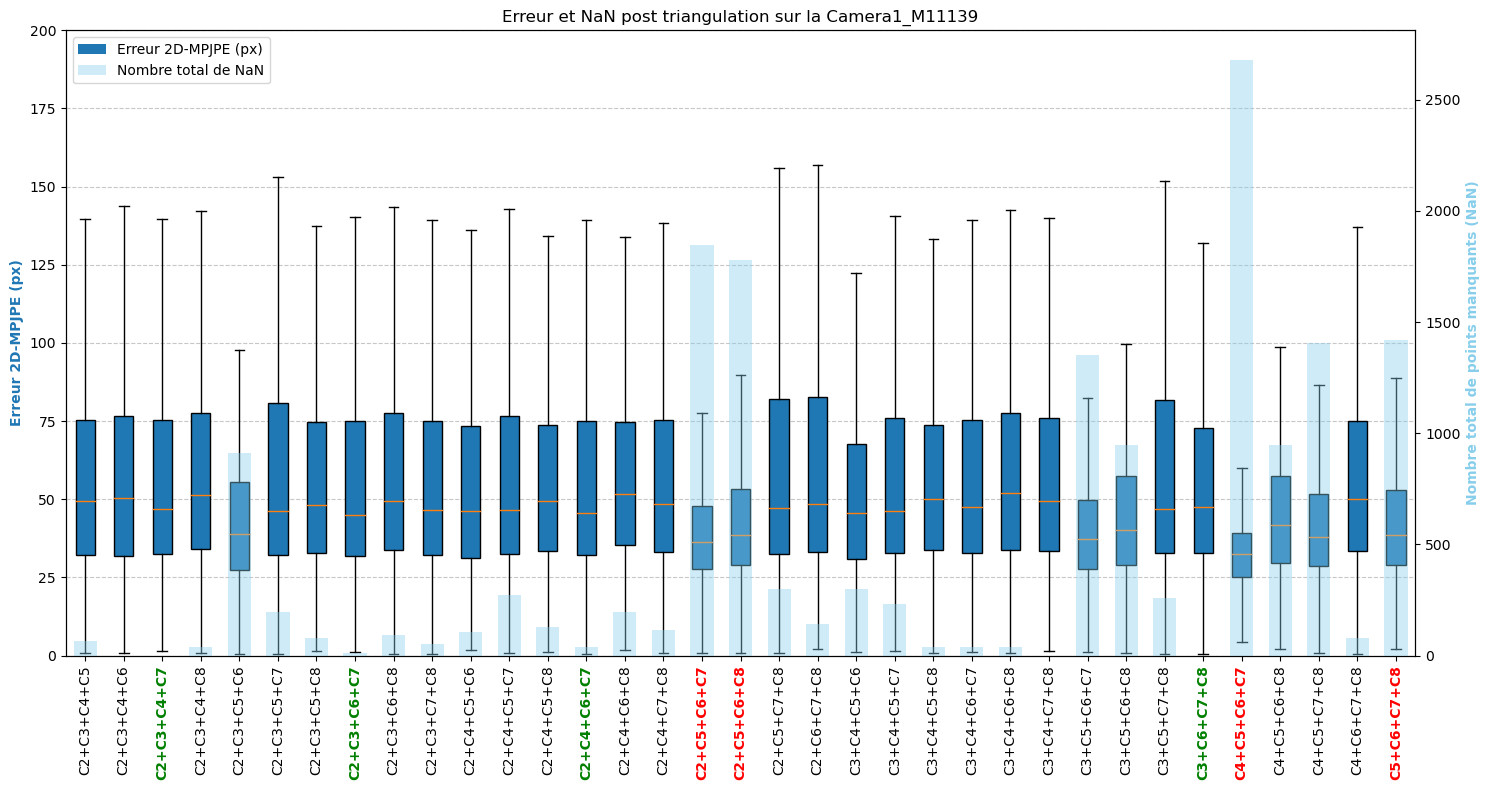

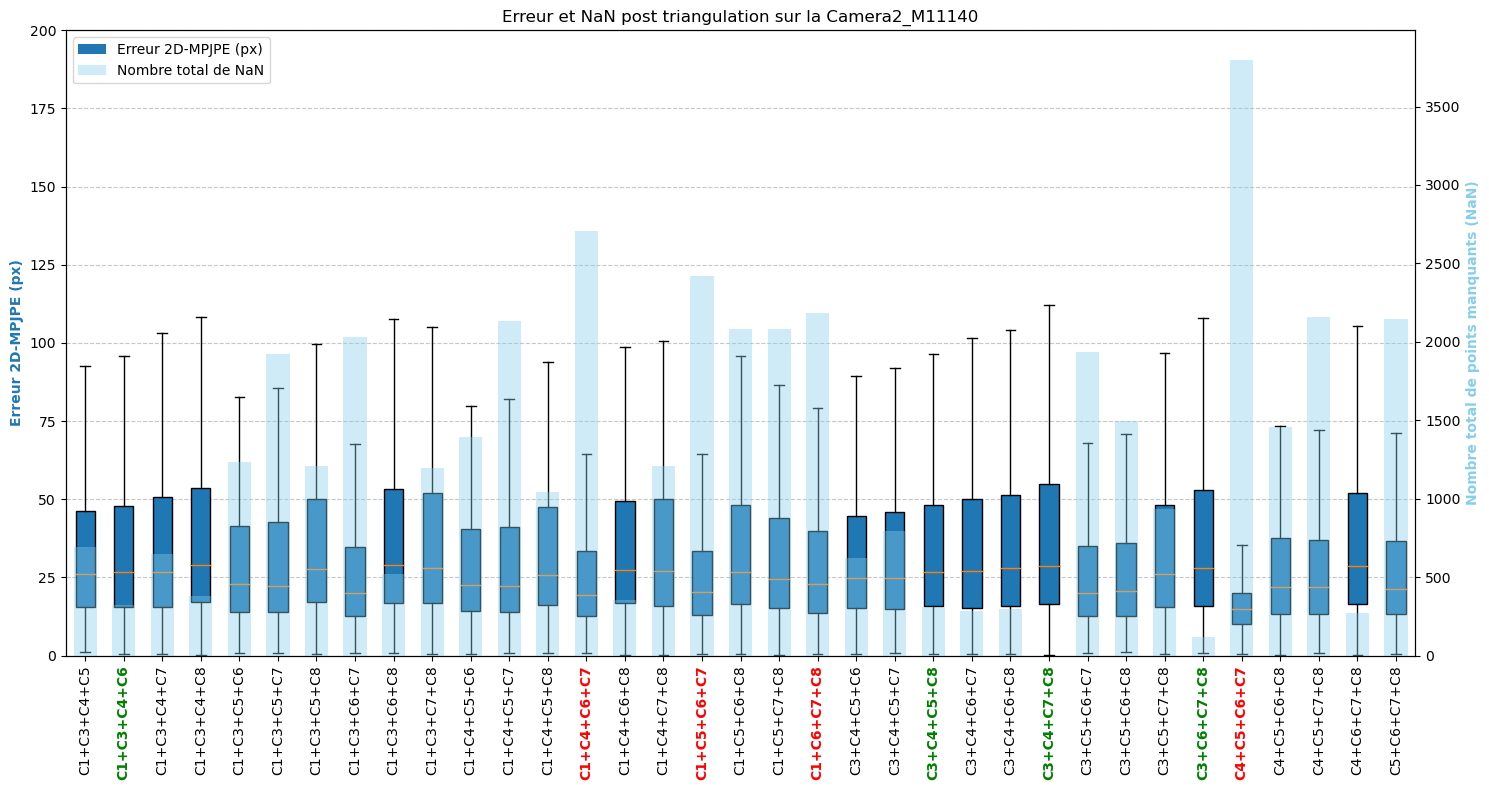

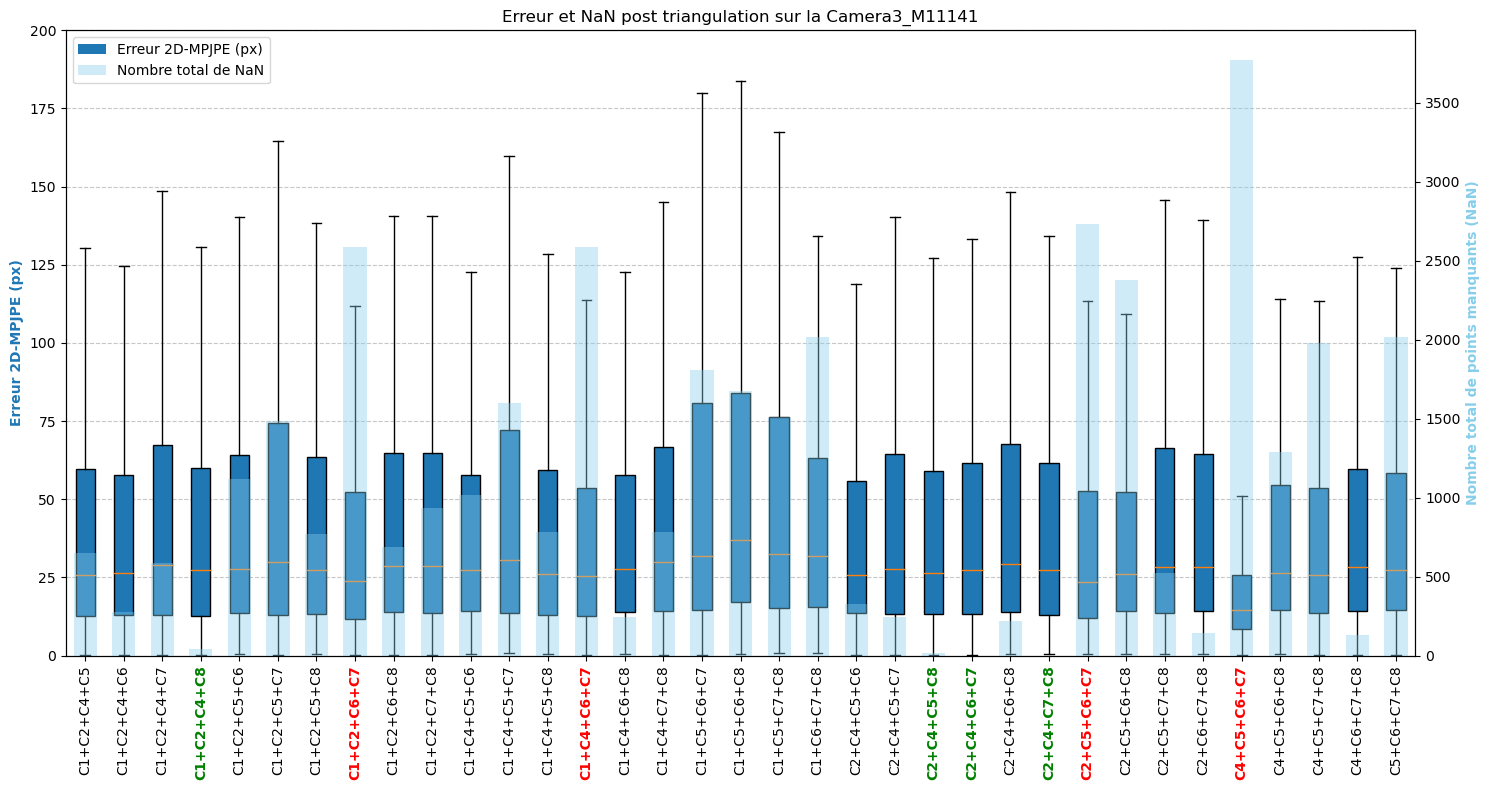

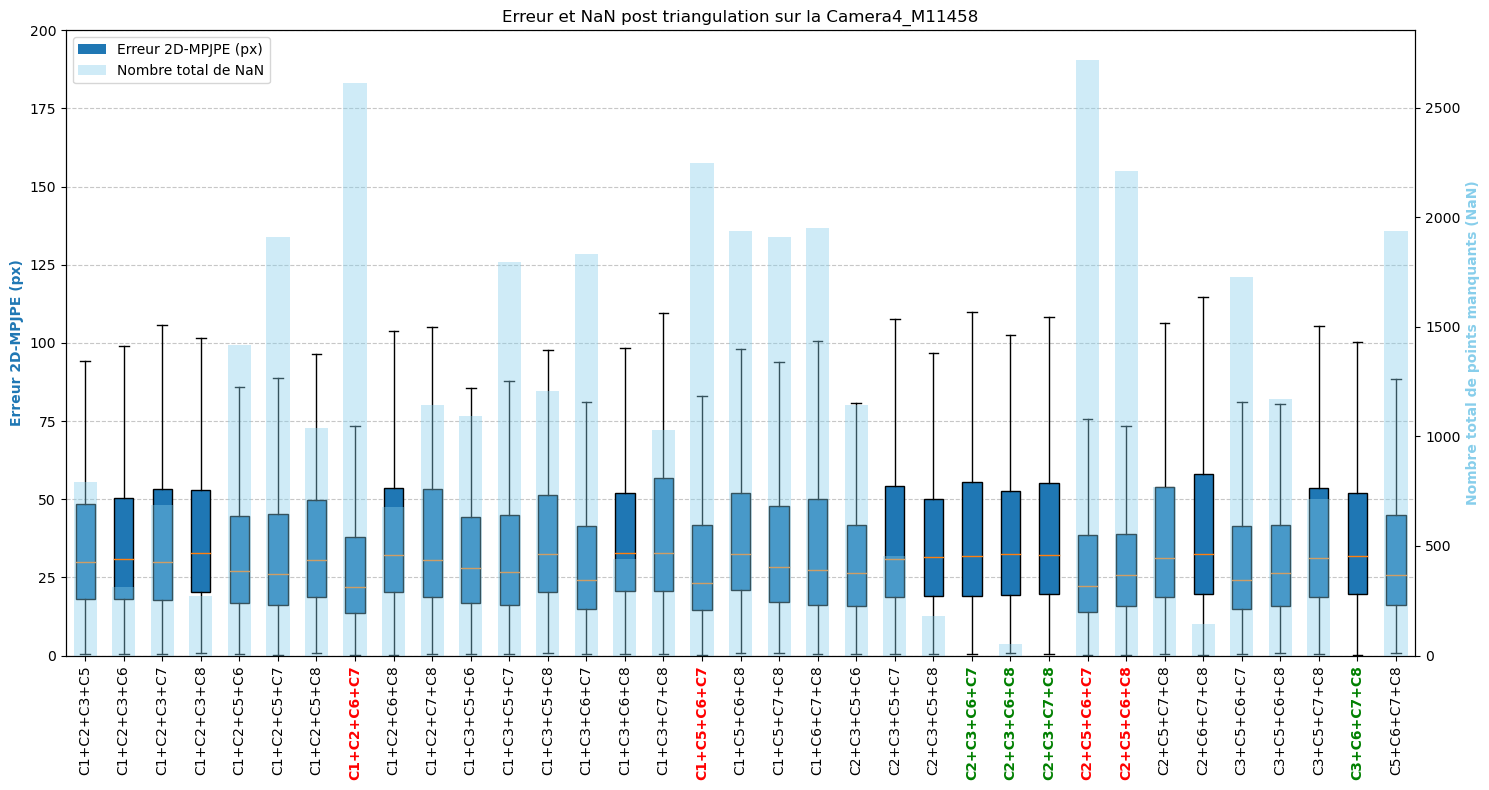

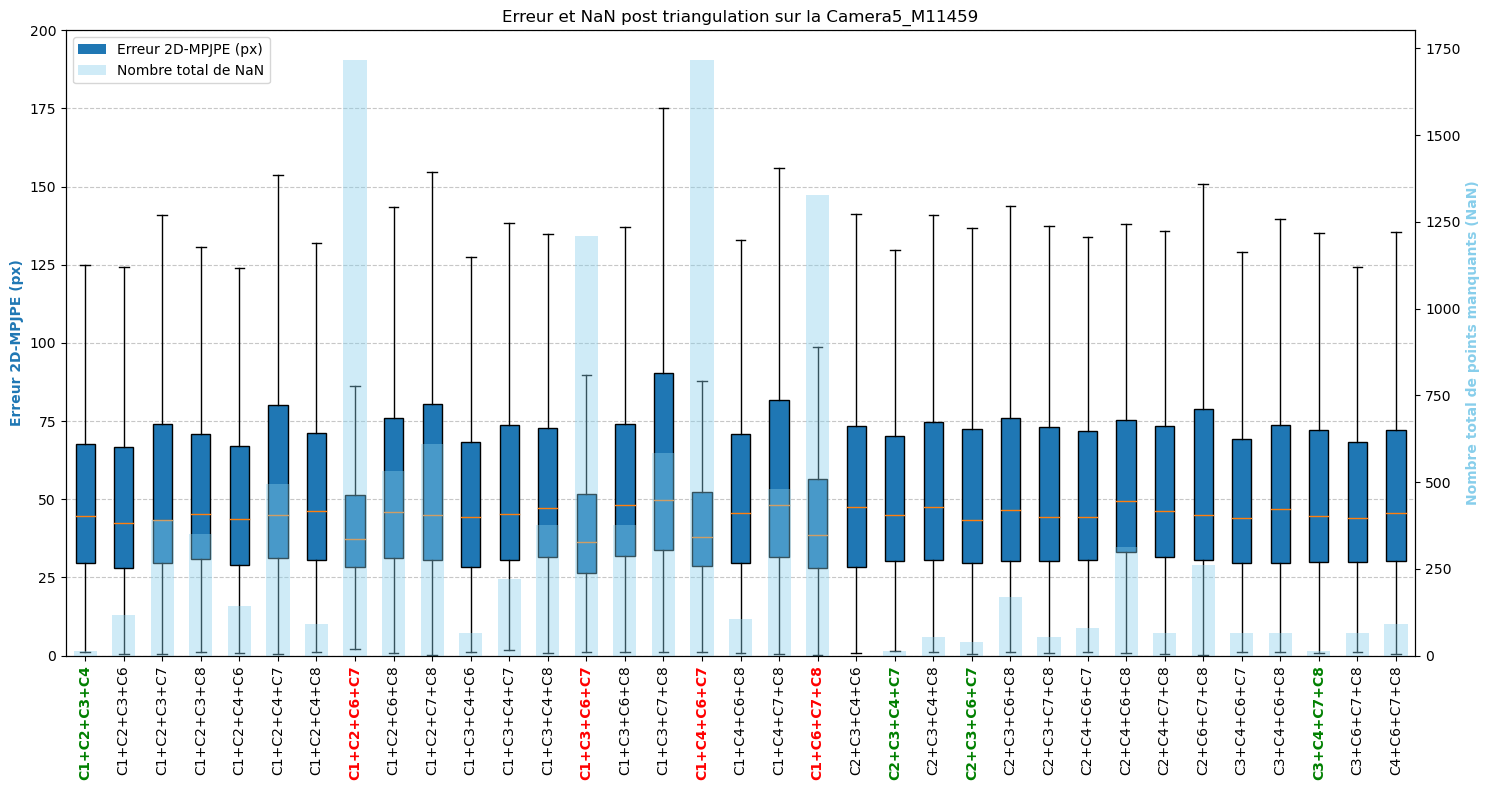

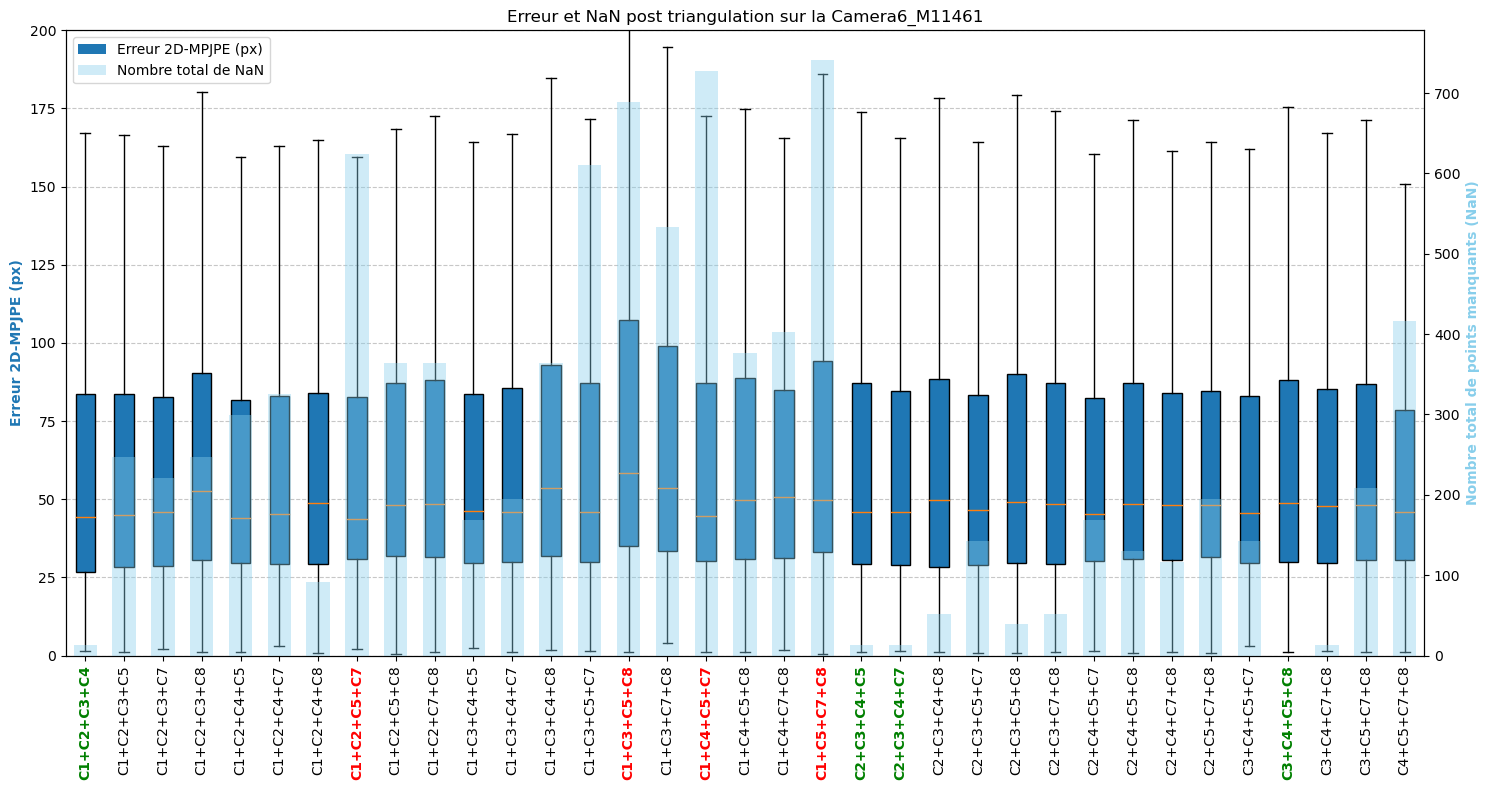

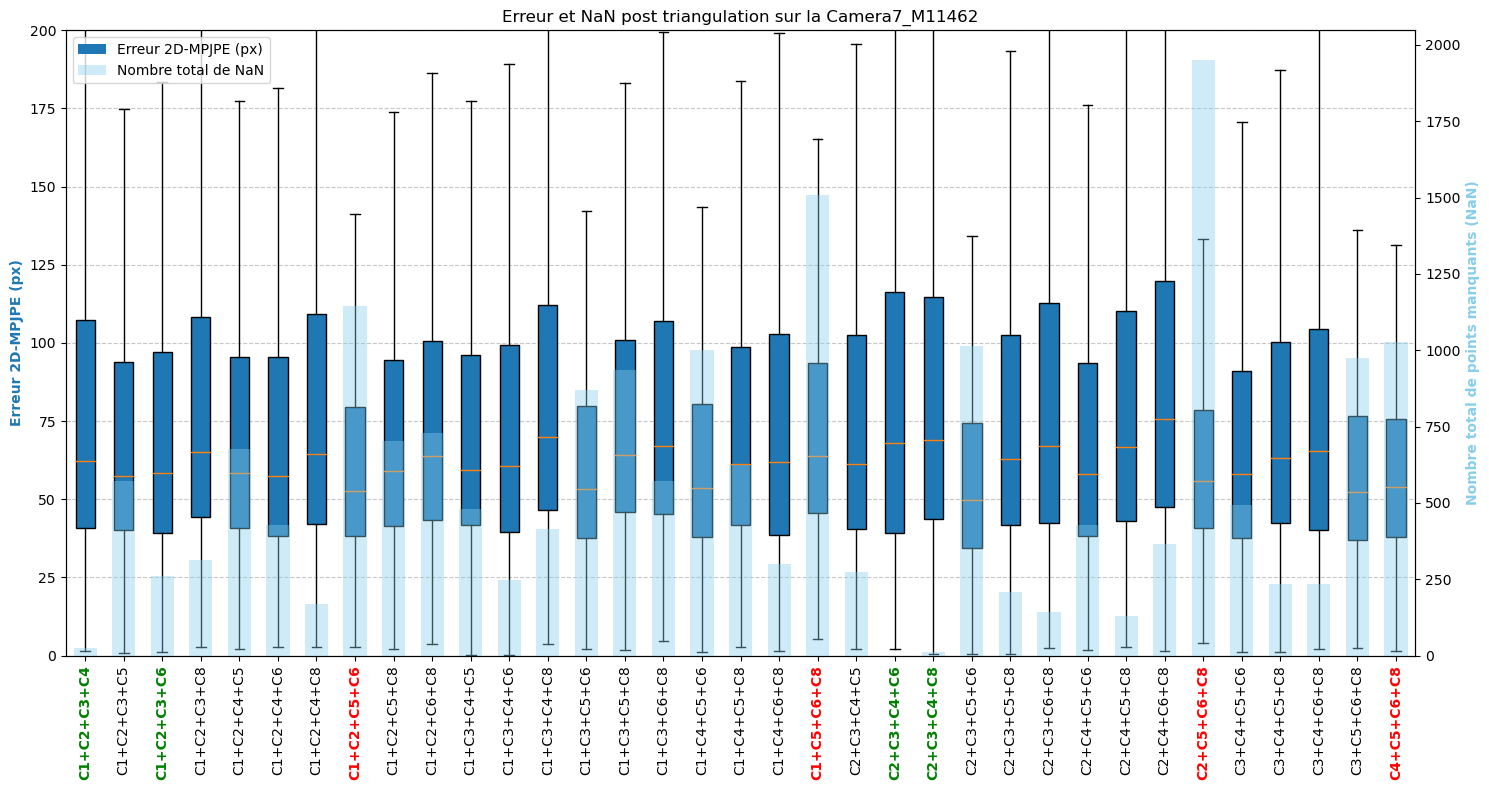

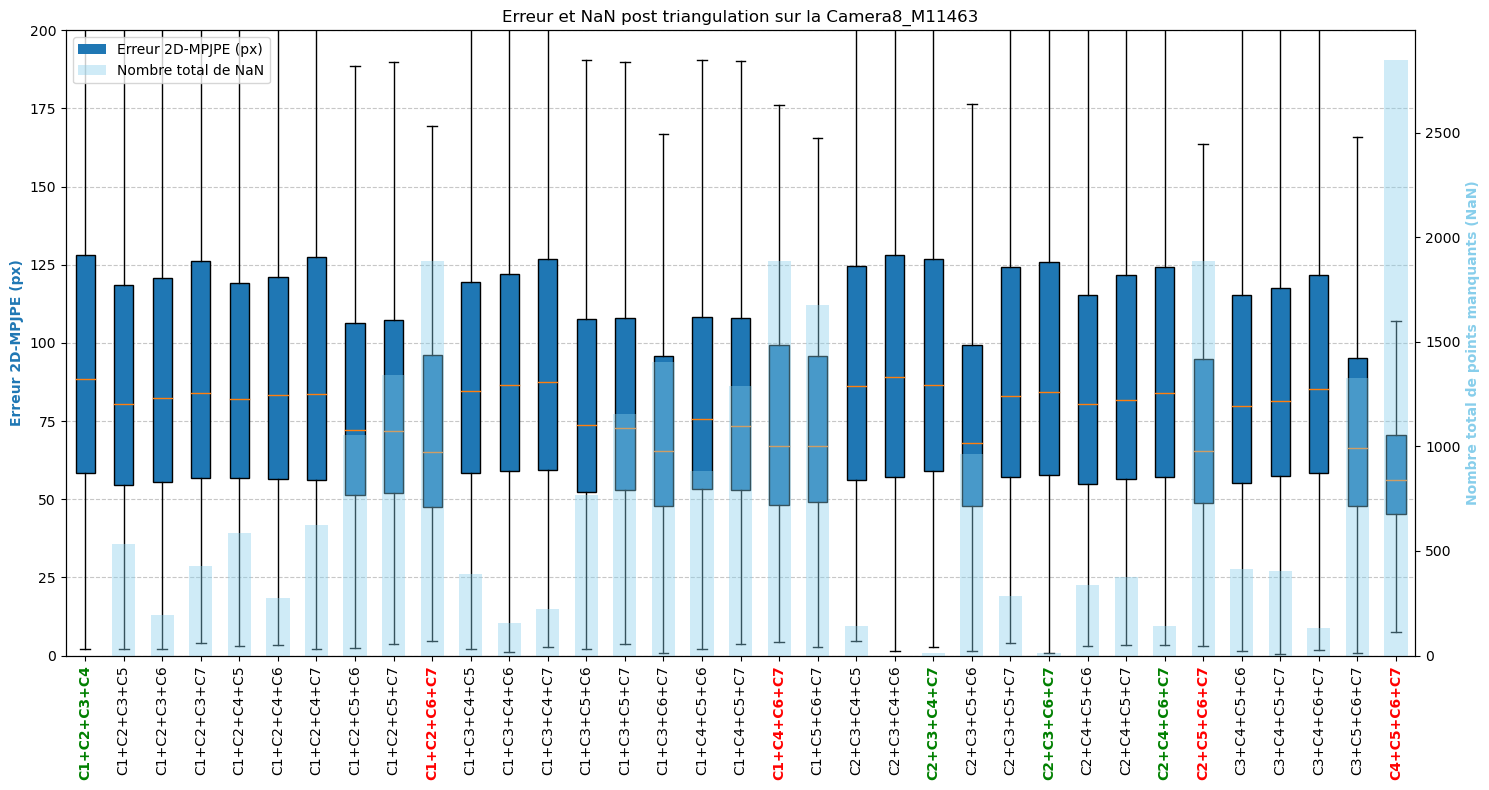


--- Stats par combinaison ---
Camera1_M11139
  C2+C3+C4+C5: {'moyenne': 59.053502949327395, 'médiane': 49.3434976032962, 'écart_type': 40.30699084978924, 'q1': 32.19956898578931, 'q3': 75.21789597200775}
  C2+C3+C4+C6: {'moyenne': 59.48958809949573, 'médiane': 50.30203630964046, 'écart_type': 42.12156883494279, 'q1': 31.803735736575376, 'q3': 76.76994736081966}
  C2+C3+C4+C7: {'moyenne': 57.236747147074745, 'médiane': 46.96021712866868, 'écart_type': 36.6199428935925, 'q1': 32.372635561264374, 'q3': 75.256290031617}
  C2+C3+C4+C8: {'moyenne': 61.12228549103512, 'médiane': 51.19965562992815, 'écart_type': 42.13041454722058, 'q1': 34.111214249986475, 'q3': 77.43073376569555}
  C2+C3+C5+C6: {'moyenne': 47.36791874498008, 'médiane': 38.75087999008454, 'écart_type': 36.44888539997462, 'q1': 27.444818595802282, 'q3': 55.55479230836582}
  C2+C3+C5+C7: {'moyenne': 65.45120014098059, 'médiane': 46.355788956670224, 'écart_type': 53.366159699764935, 'q1': 32.249087922634246, 'q3': 80.76218226920

In [16]:
model = 'vit'

matching_2d = matching_vit
matching_3d = matching_pose2sim_vit

cameras = ['Camera1_M11139', 'Camera2_M11140', 'Camera3_M11141',
           'Camera4_M11458', 'Camera5_M11459', 'Camera6_M11461',
           'Camera7_M11462', 'Camera8_M11463']

# define Rotation for Pose2Sim to World
R = np.array([[0, 0, 1],
              [-1, 0, 0],
              [0, 1, 0]])

dist_per_cam = get_MPJPE_per_cam_CoM(model, cameras, R, K, projMat, matching_2d, matching_3d)

plot_MPJPE_per_cam(dist_per_cam, model, showNaN=True, ylim=200)

get_all_stats(dist_per_cam)

### Show detections and reprojections on images

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

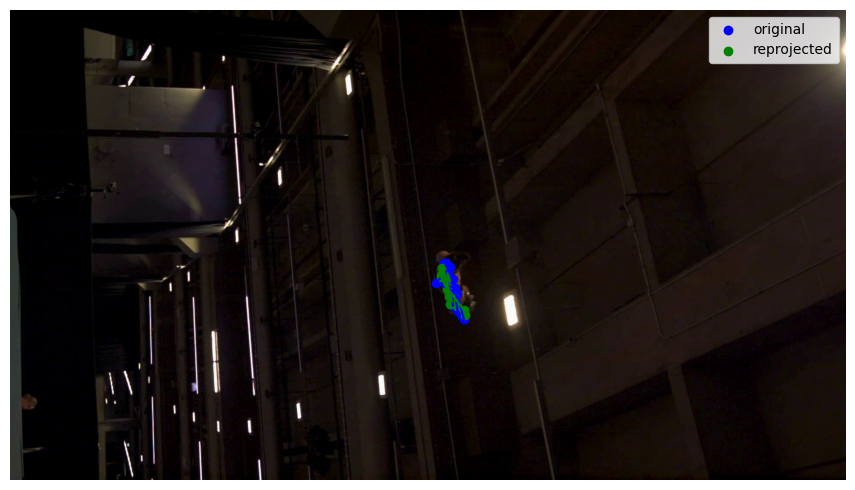

160 160


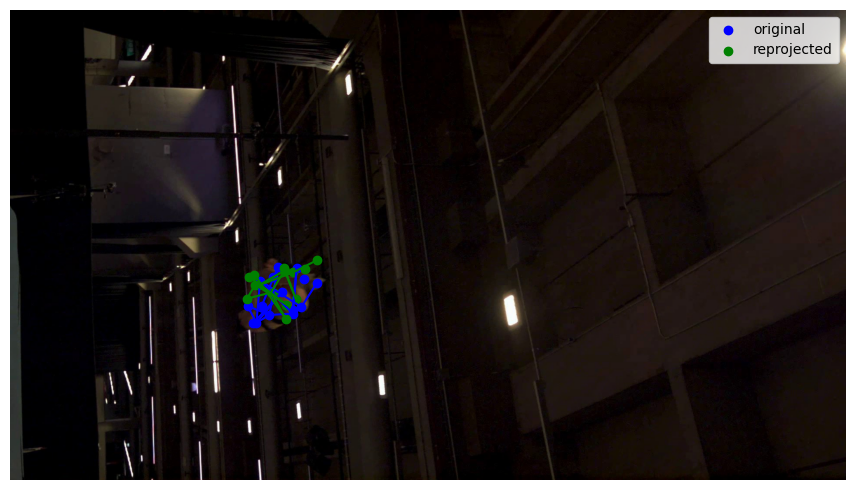

310 310


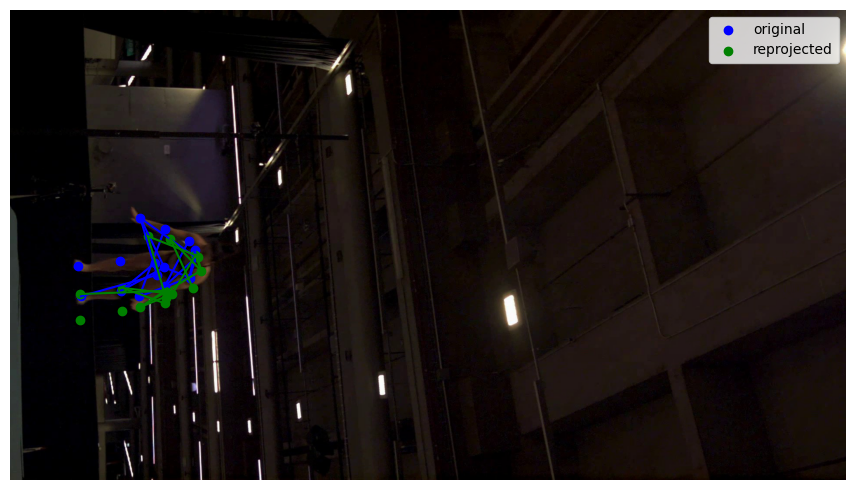

460 460


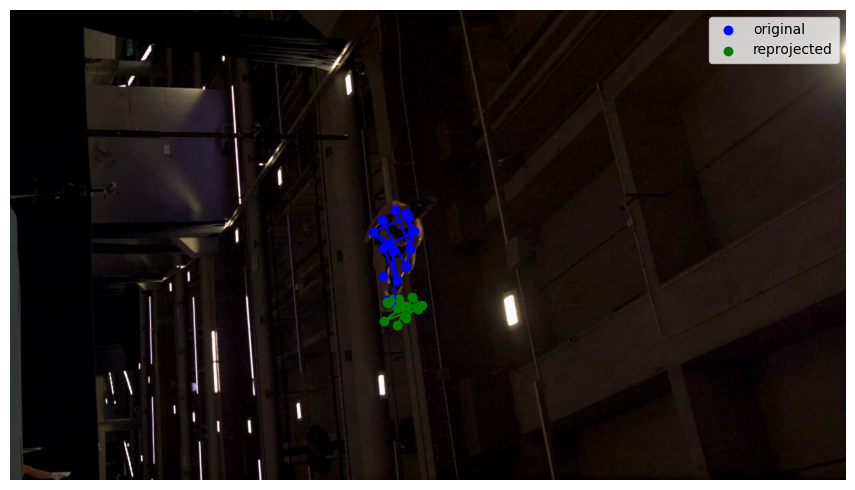

610 610


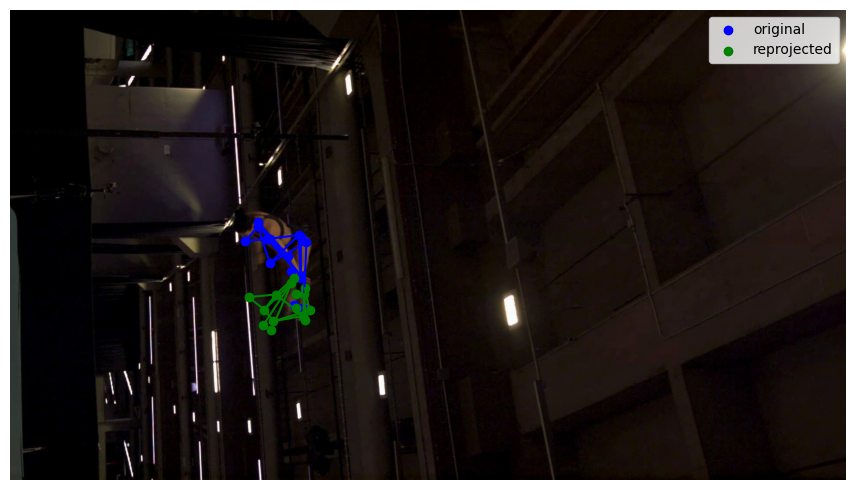

760 760


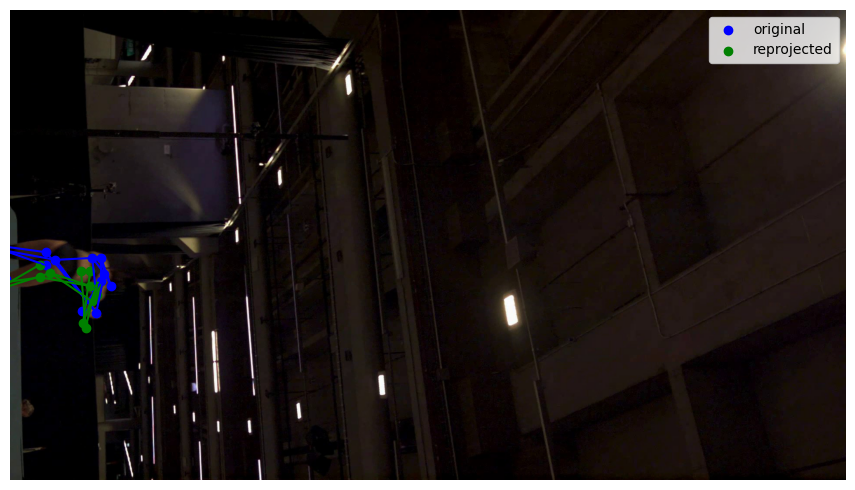

910 910


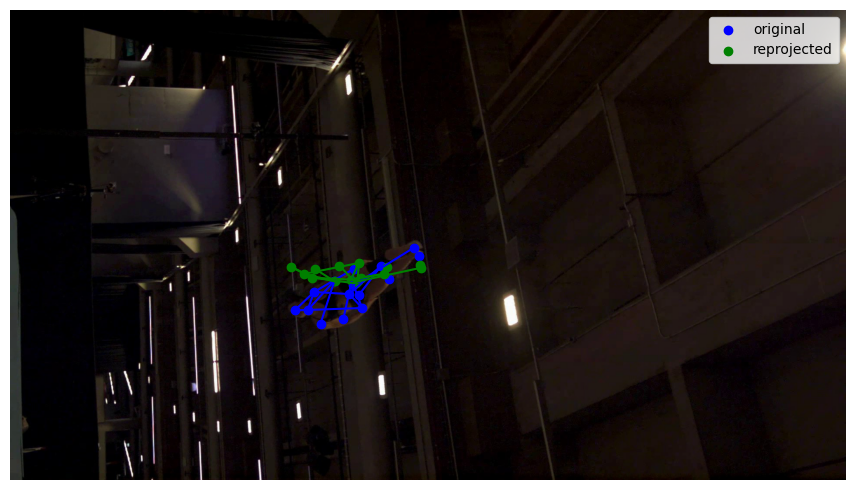

1060 1060


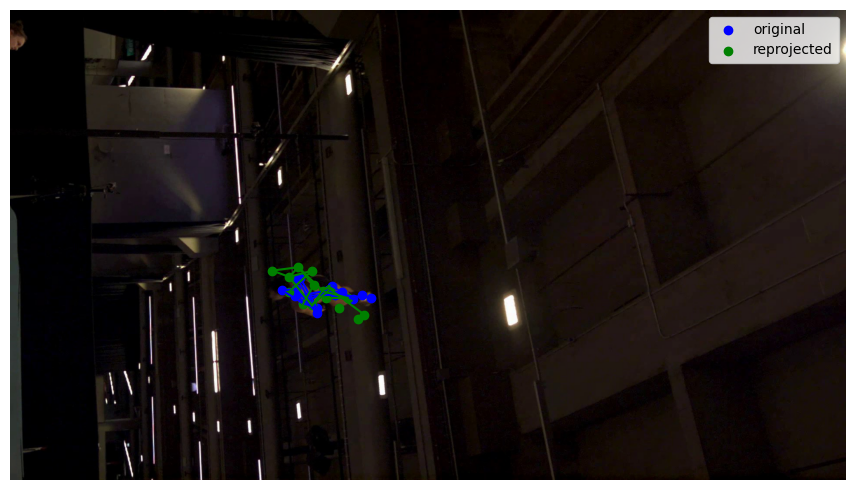

1210 1210


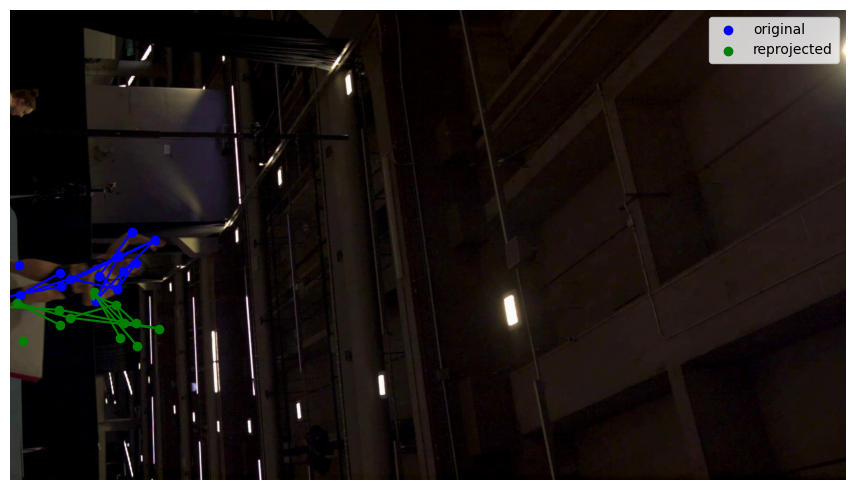

In [17]:
from compare_keypoints_3D import load_trc, extract_trc_positions, get_trc_frames
from multiview_consistency import computeP

plt.close()

routine = '1_partie_0429_002'
trc_path = f'/home/lea/trampo/Pose2Sim/pose-3d-4DHumans-multi/{routine}/C1+C2+C3+C4+C5+C6+C7/{routine}.trc'

trc_data, marker_names = load_trc(trc_path)
trc_positions = extract_trc_positions(trc_data, marker_names)

P_all, K_all = computeP('/home/lea/trampo/Pose2Sim/Calibration/Calib_all.toml')

cam_idx = 7
P = P_all[cam_idx]

pkl_path = f'/home/lea/trampo/Pose2Sim/pose_all_4dhumans/{routine}-{cameras[cam_idx]}_json' #Camera{cam_idx+1}

frames = get_trc_frames(trc_data, marker_names)
print(frames)

# define Rotation for Pose2Sim to World
R = np.array([[0, 0, 1],
              [-1, 0, 0],
              [0, 1, 0]])

for frame in frames[10::150]:
    pkl_file = os.path.join(pkl_path, f'frame_{frame:06d}.json')
    pkl_positions = load_2d_keypoints(pkl_file)
    try:
        pkl_2d = (np.array(pkl_positions[0]).T)[matching_humans]
        pkl_2d = pkl_2d.reshape((-1, 2))
    except IndexError:
        continue
    
    print(frame, frames.index(frame))
    points_3d = trc_positions[frames.index(frame)][matching_pose2sim]
    points_2d, mask = project_points_to_camera(points_3d*1000, K[cam_idx], projMat[cam_idx], R)

    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    img = mpimg.imread(f'/home/lea/trampo/4DHumans/outputs/_DEMO/{routine}-{cameras[cam_idx]}/img/{frame:06d}.jpg')
    ax.imshow(img)

    ax.scatter(*pkl_2d.T, color='blue', label='original')
    ax.scatter(*points_2d.T, color='green', label='reprojected')

    draw_skeleton(pkl_2d, 'blue', ax)
    draw_skeleton(points_2d, 'green', ax)

    ax.set_xlim(0, 1920)
    ax.set_ylim(0, 1080)
    ax.axis('off')
    plt.legend()
    plt.tight_layout()
    plt.show()

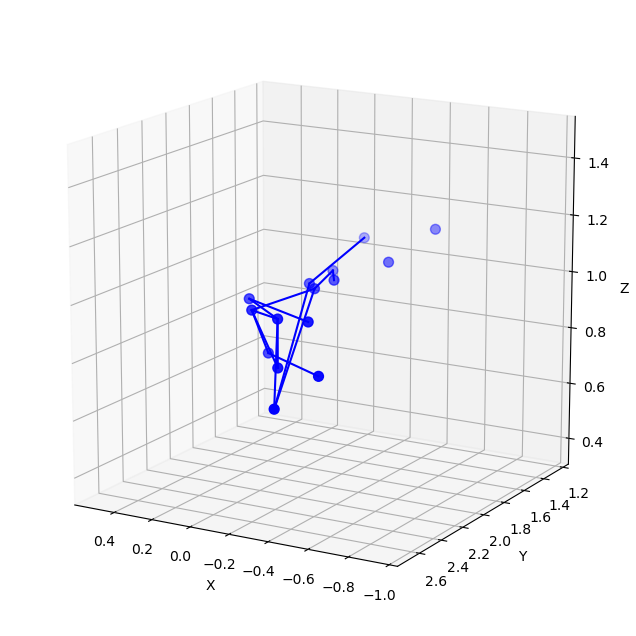

In [18]:
#%matplotlib widget
fig = plt.figure(figsize=(8, 8))

# Raw version
ax1 = fig.add_subplot(111, projection='3d')
ax1.scatter(*points_3d.T, c='blue', s=50)
ax1.axis('equal')

draw_skeleton(points_3d, 'blue', ax1)

ax1.set_xlabel('X'); ax1.set_ylabel('Y'); ax1.set_zlabel('Z')
ax1.set_box_aspect([1,1,1])
ax1.view_init(elev=15, azim=120)

plt.show()